# Prior Predictive Modeling

This guide provides an introduction to prior predictive modeling using PyMC (and PyMC Marketing) and the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing. Before diving into the technical details, let's understand why priors are crucial in Bayesian analysis and their practical importance in industry applications.

## Understanding Bayesian Inference

Bayesian inference is based on Bayes' theorem, which provides a formal way to update our beliefs about parameters $\theta$ (say, saturation or decay rate in a marketing mix models) given observed data $y$:

$$p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)}$$

Where:
- $p(\theta|y)$ is the posterior probability (what we want to learn)
- $p(y|\theta)$ is the likelihood (how the data is generated)
- $p(\theta)$ is the prior probability (our initial beliefs)
- $p(y)$ is the evidence (a normalizing constant), which can be written as $p(y) = \displaystyle{ \int p(y|\theta)p(\theta)d\theta }$

The posterior distribution combines our prior knowledge with the observed data to give us updated beliefs about the parameters. In practice, we often work with the unnormalized posterior:

$$p(\theta|y) \propto p(y|\theta)p(\theta)$$

This is because the normalizing constant $p(y)$ is often intractable to compute directly.

### Why Priors Matter in Industry

In industry applications, priors serve several crucial purposes:

1. **Domain Knowledge Integration**:
   - Incorporating expert knowledge into models
   - Leveraging historical data from similar projects
   - Encoding business constraints and requirements

2. **Risk Management**:
   - Preventing unrealistic predictions
   - Ensuring stable model behavior
   - Managing uncertainty in decision-making

3. **Data Efficiency**:
   - Making models work with limited data
   - Faster convergence to reasonable solutions
   - Robust predictions in new scenarios

4. **Model Regularization**:
   - Preventing overfitting
   - Handling multicollinearity
   - Dealing with sparse data

### Common Prior Specification Scenarios

In marketing analytics, you'll often encounter these scenarios:

1. **Marketing Mix Models**:
   - Media channel effectiveness (typically positive)
   - Diminishing returns (shape constraints)
   - Lift tests calibration

2. **Customer Lifetime Value**:
   - Purchase rates (positive values)
   - Churn probabilities (between 0 and 1)
   - Monetary value distributions (positive, often log-normal)

3. **A/B Testing**:
   - Conversion rates (bounded between 0 and 1)
   - Lift measurements (centered around small effects)
   - Revenue impacts (potentially heavy-tailed)

## What is Prior Predictive Modeling?

Prior predictive modeling is a crucial step in Bayesian workflow that helps us validate our prior choices before seeing the actual data. The process involves:

1. **Specification**: 
   - Define prior distributions for model parameters
   - Encode domain knowledge and constraints
   - Document assumptions and choices

2. **Simulation**:
   - Sample parameters from prior distributions
   - Generate synthetic data using the model structure
   - Create multiple scenarios of possible outcomes

3. **Validation**:
   - Check if simulated data matches domain expertise
   - Verify that impossible scenarios are excluded
   - Ensure reasonable coverage of possible outcomes

### Benefits in Practice

1. **Early Problem Detection**:
   - Identify unrealistic assumptions
   - Catch numerical issues before model fitting
   - Validate model structure

2. **Stakeholder Communication**:
   - Visualize model implications
   - Justify modeling choices
   - Set realistic expectations

3. **Model Development**:
   - Iterate on prior choices efficiently
   - Compare alternative specifications
   - Document model evolution

4. **Risk Assessment**:
   - Understand model limitations
   - Identify edge cases
   - Plan for failure modes

The prior predictive distribution $p(y)$ represents our beliefs about the data before we observe it. Mathematically, it's the distribution of the data marginalized over the prior:

$$p(y) = \int p(y|\theta)p(\theta)d\theta$$

In practice, we can sample from this distribution by:
1. Drawing parameters from the prior: $\theta^{(s)} \sim p(\theta)$
2. Generating data from the likelihood: $y^{(s)} \sim p(y|\theta^{(s)})$

This process helps us validate our model in several ways:

1. **Parameter Space Coverage**: 
   The samples $\{\theta^{(s)}\}_{s=1}^S$ show us what parameter values we consider plausible

2. **Data Space Coverage**: 
   The samples $\{y^{(s)}\}_{s=1}^S$ show us what data our model can generate

3. **Model Sensitivity**: 
   The relationship between $\theta^{(s)}$ and $y^{(s)}$ shows how parameters influence predictions

Let's explore these concepts through practical examples using the {class}`Prior <pymc_marketing.prior.Prior>` class from PyMC-Marketing.


## Prepare Notebook

In [28]:
from itertools import product

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns
from numpy.typing import NDArray

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

seed: int = sum(map(ord, "prior"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple Example: Normal Distribution

Let's start with a simple example using a normal distribution. We'll:
1. Generate a synthetic dataset
2. Study the observed distribution
3. Set a prior for the mean and standard deviation
4. Sample from its prior predictive distribution


First we generate a synthetic dataset from a normal distribution with mean one and standard deviation two.

In [2]:
true_mu: float = 1.0
true_sigma: float = 2.0
n_observations: int = 200

data: NDArray = rng.normal(loc=true_mu, scale=true_sigma, size=n_observations)

sample_mean: float = data.mean()
sample_std: float = data.std()

Let's visualize the observed data.



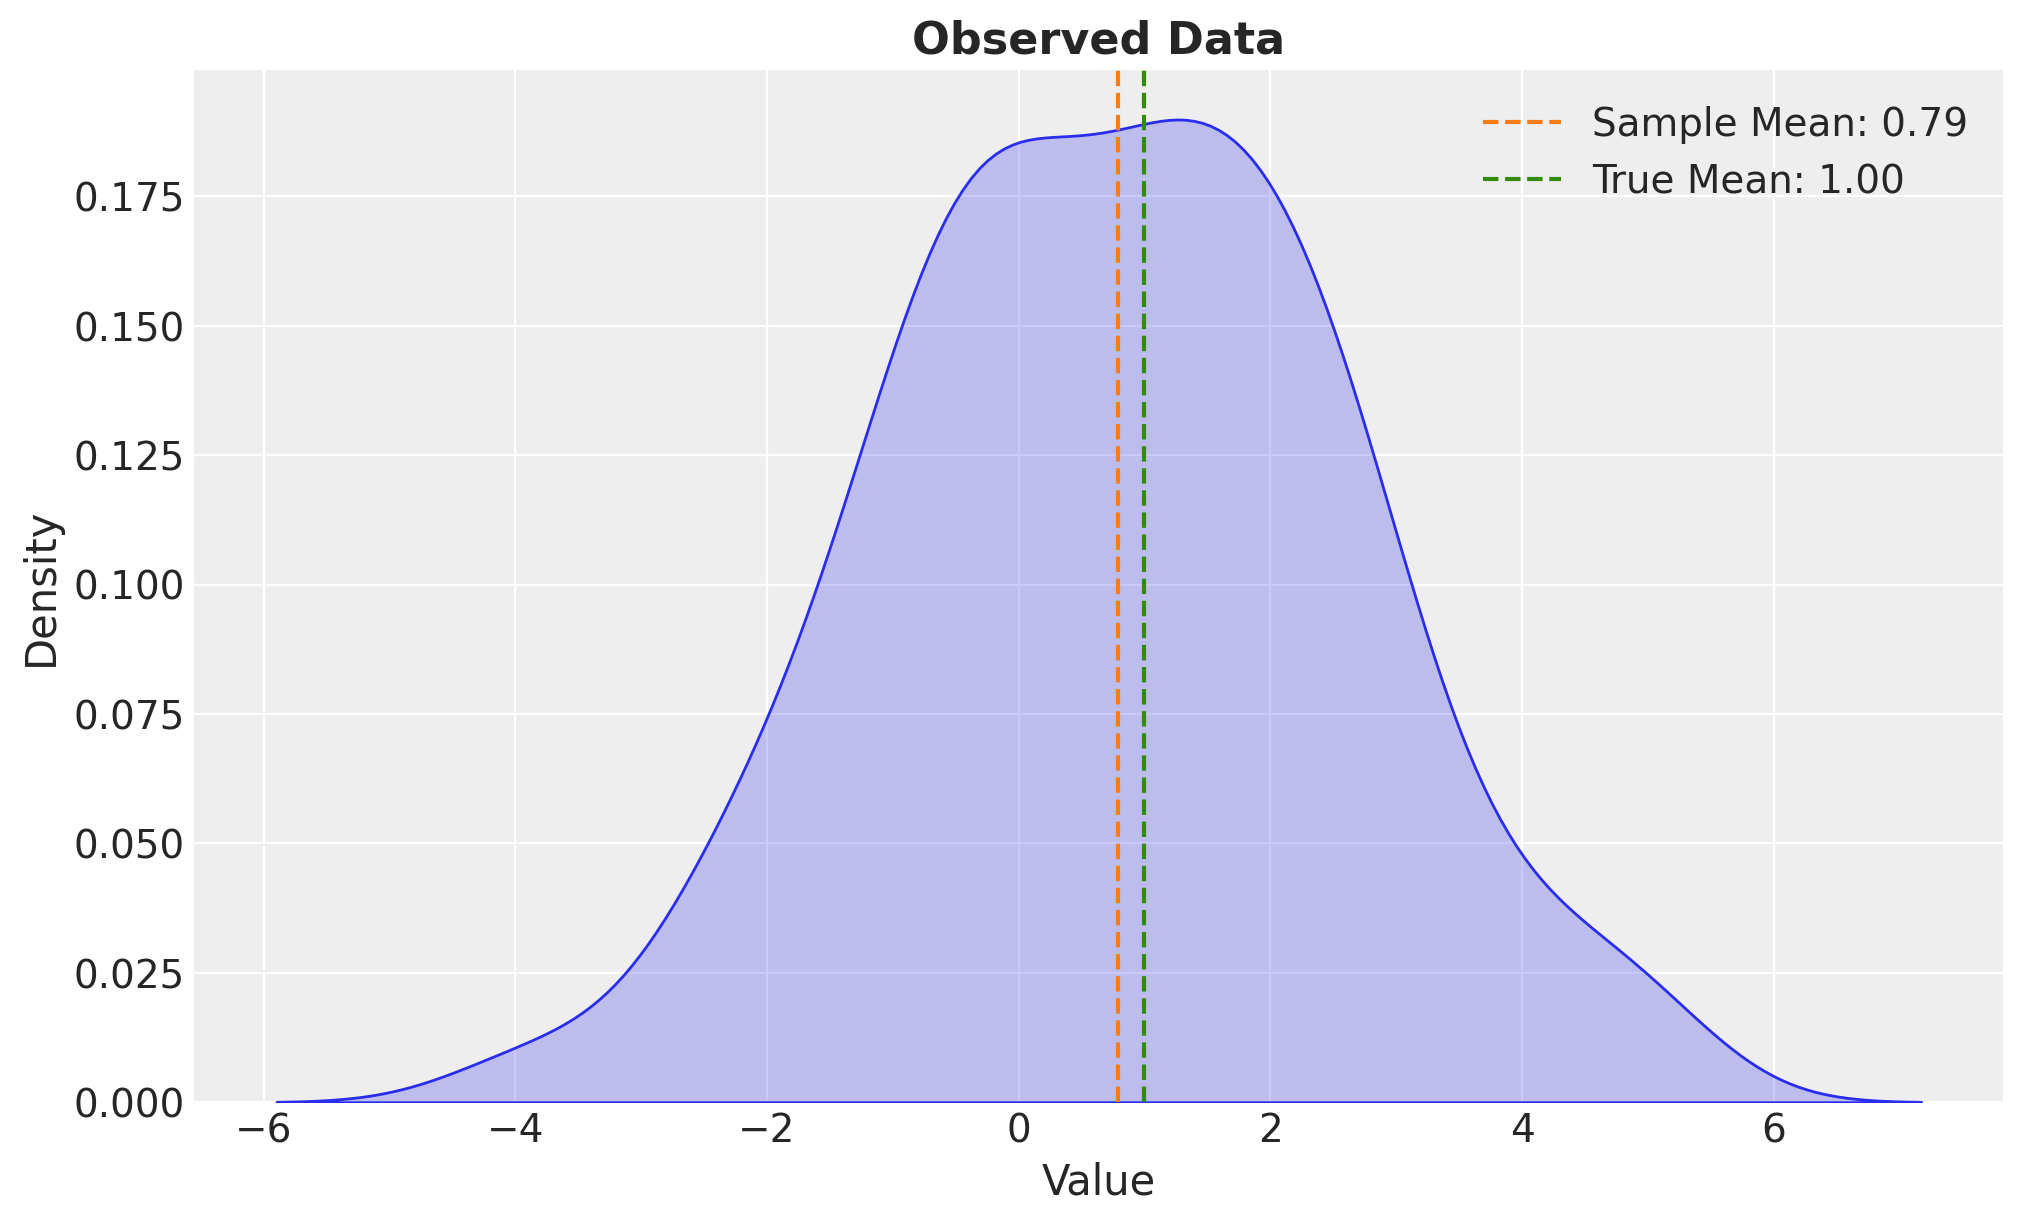

In [3]:
fig, ax = plt.subplots()
sns.kdeplot(data, fill=True, color="C0", ax=ax)
ax.axvline(
    sample_mean, color="C1", linestyle="--", label=f"Sample Mean: {sample_mean:.2f}"
)
ax.axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.2f}")
ax.legend()
ax.set(title="Observed Data", xlabel="Value", ylabel="Density")
ax.set_title("Observed Data", fontsize=16, fontweight="bold");

We assume we do not know the true mean and standard deviation of the data (as in almost all cases). Our idea is to fit a bayesian model to try to recover the true parameters.

We consider the parametric form of the data:

$$
y \sim \text{Normal}(\mu, \sigma)
$$

What could be sensible priors for the mean and standard deviation? This is where the prior predictive modeling comes in. 

### Fixed Mean and Standard Deviation

First, we consider the simple case where we set fixed values for the mean and standard deviation and we sample from the prior predictive distribution (the normal distribution). 

Consider the following values for the mean and standard deviation:

In [4]:
mu_1, mu_2 = -2, 0
sigma_1, sigma_2 = 0.5, 3

Given these values, we can simply sample from a normal distribution with these parameters and compare it with the observed data.


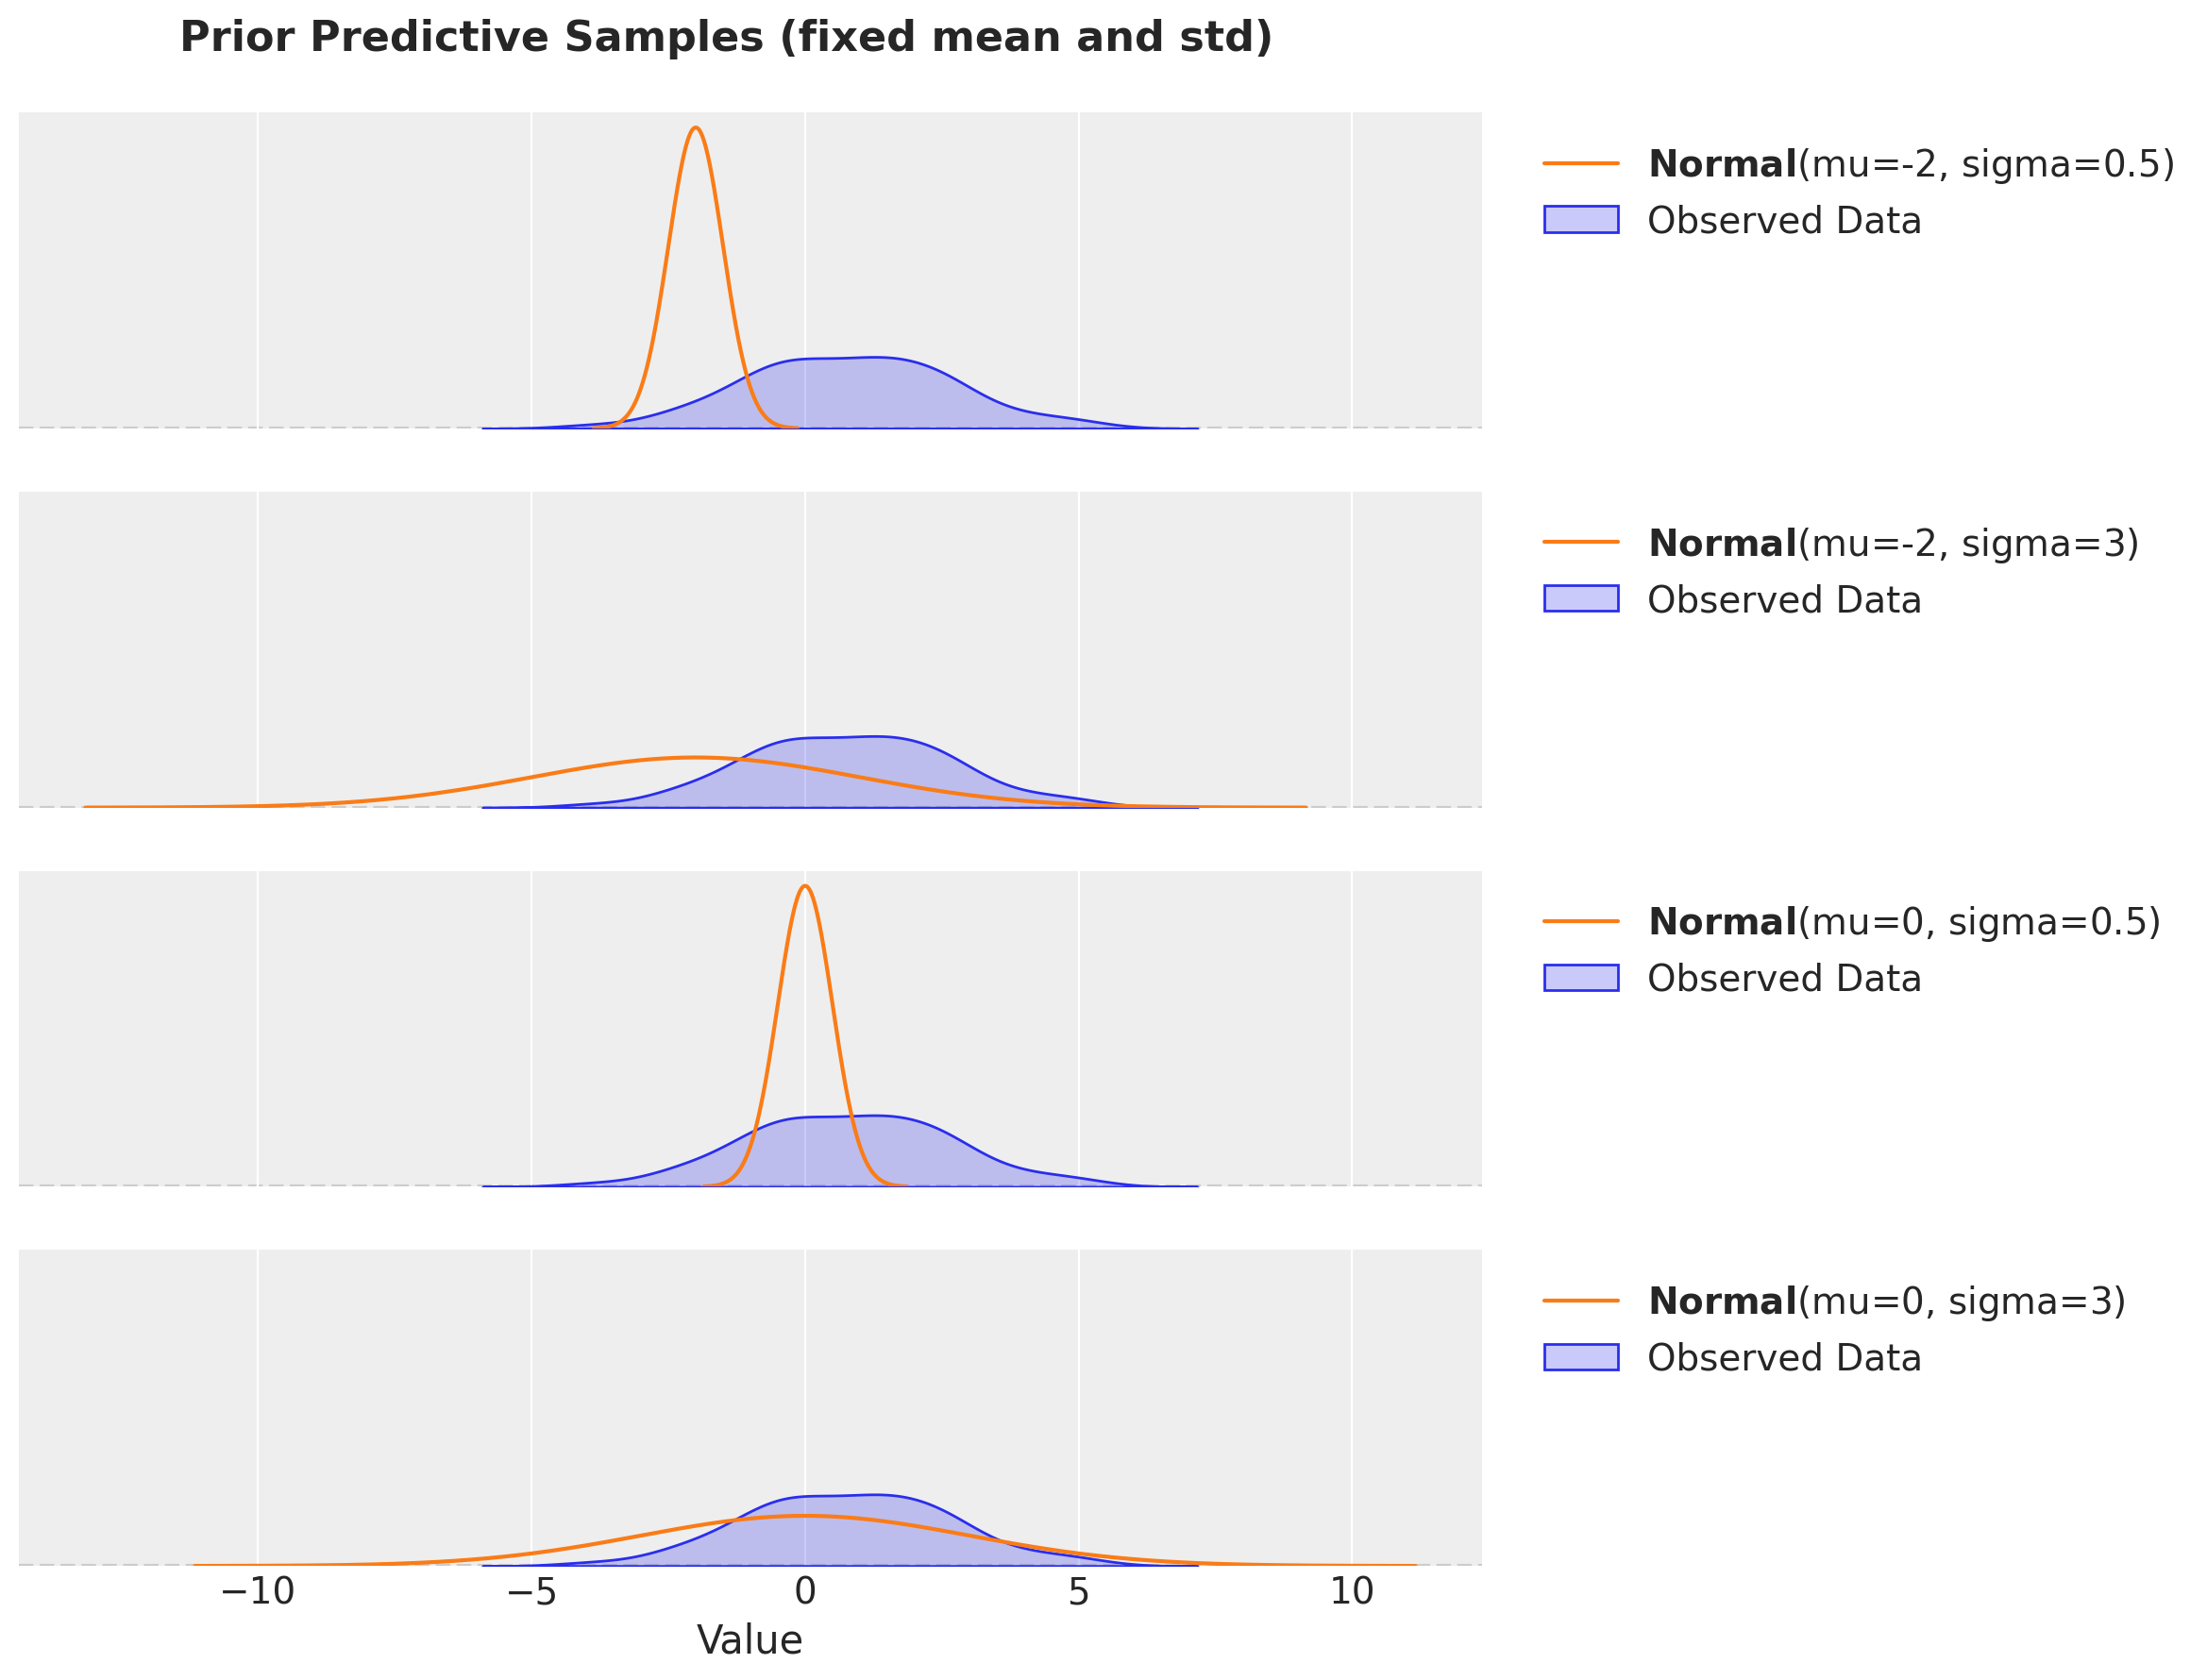

In [5]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, (mu, sigma) in enumerate(product((mu_1, mu_2), (sigma_1, sigma_2))):
    ax = axes[i]
    normal_prior = pz.Normal(mu=mu, sigma=sigma)
    normal_prior.plot_pdf(color="C1", ax=ax)
    sns.kdeplot(data, fill=True, color="C0", label="Observed Data", ax=ax)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.set(xlabel="Value", ylabel="Density")

fig.suptitle(
    "Prior Predictive Samples (fixed mean and std)",
    fontsize=16,
    fontweight="bold",
    y=0.93,
);

Looking at the plots above, we can see how different combinations of mean (μ) and standard deviation (σ) parameters affect the fit to our observed data:

- $\mu=-2, \sigma=0.5$: The distribution is too narrow and centered too far to the left
- $\mu=-2, \sigma=3$: Better spread but still centered too far left
- $\mu=0, \sigma=0.5$: Better centered but too narrow
- $\mu=0, \sigma=3$: This appears to be the best fit, with both good center and spread matching the observed data

This visual comparison helps us understand that priors centered around $\mu=0$ with a wider standard deviation ($\sigma=3$) may be more appropriate for our data.


### Prior Predictive Sampling

Now we can take a step forward and instead of fixing the mean and standard deviation, we can set a prior for them. To start, we set the following priors for the mean and standard deviation:

- $\mu \sim \text{Normal}(0, 2)$
- $\sigma \sim \text{Exponential}(1/3)$

We first sample from the model parameters.

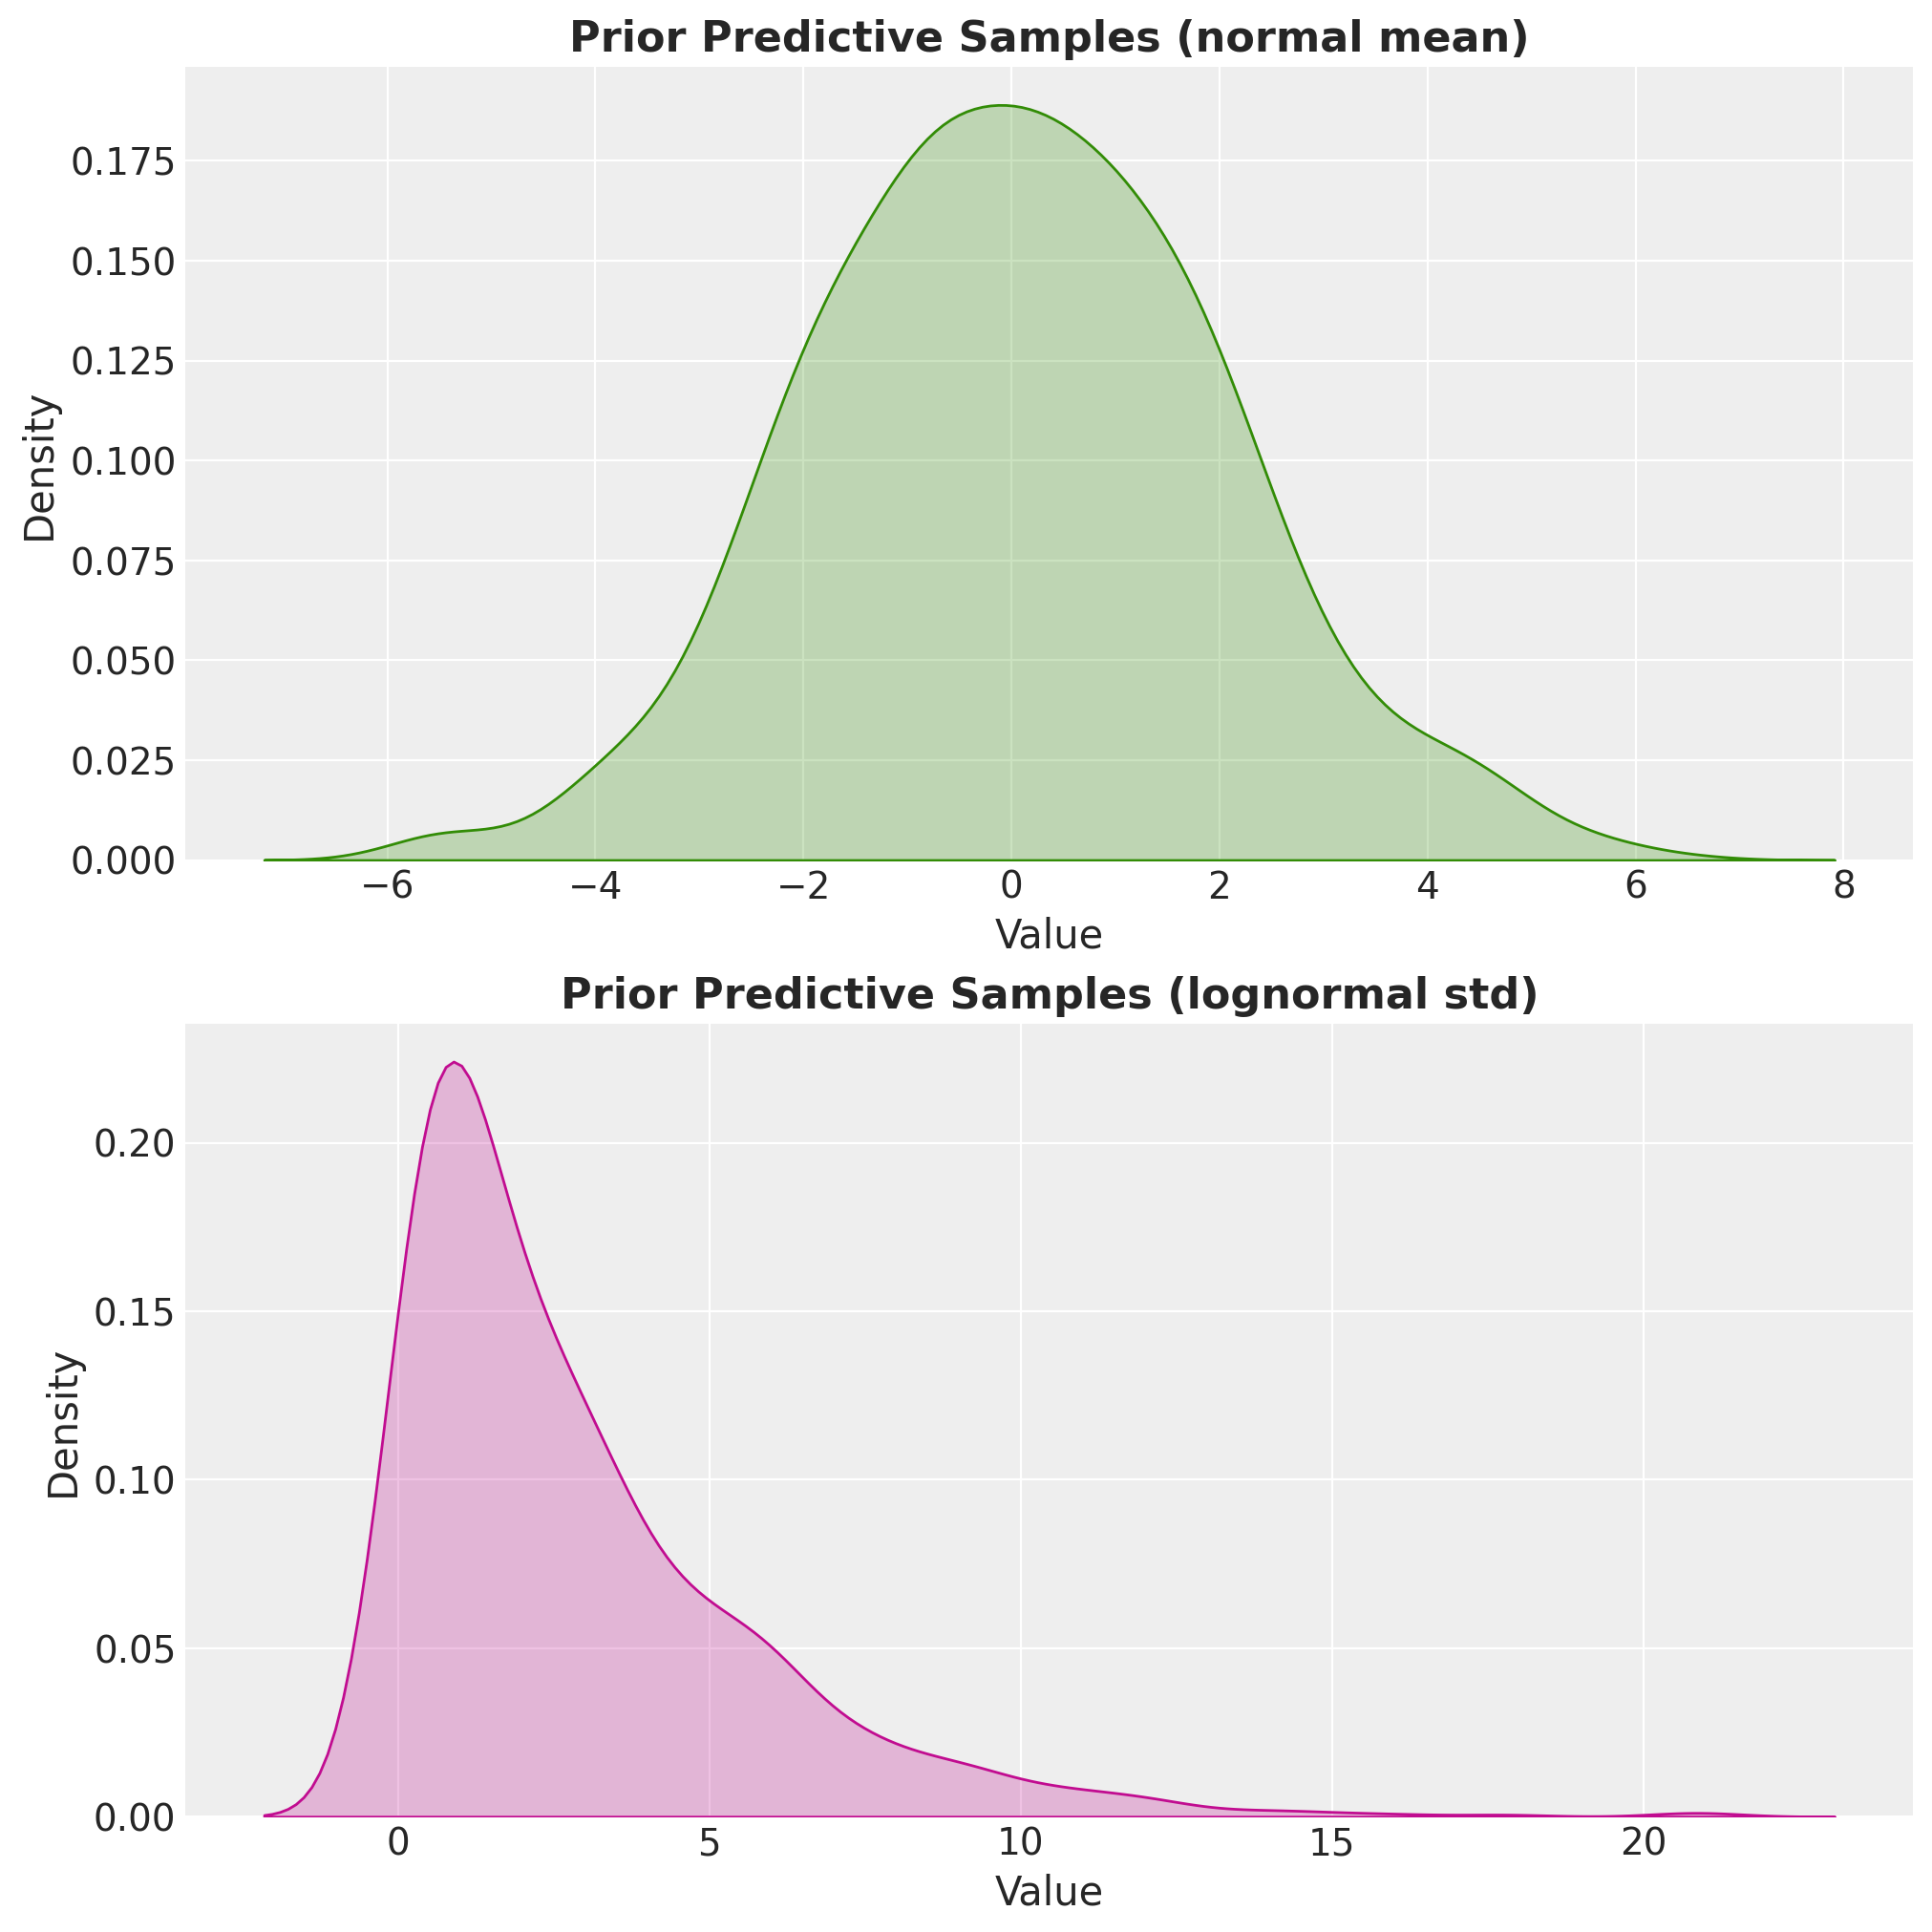

In [6]:
# Set the number of prior samples
n_prior_samples: int = 1_000

# Sample from the prior distributions
mus = rng.normal(loc=0, scale=2, size=n_prior_samples)
sigmas = rng.exponential(scale=3, size=n_prior_samples)

fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 10),
    sharex=False,
    sharey=False,
    layout="constrained",
)

sns.kdeplot(mus, fill=True, color="C2", ax=ax[0])
ax[0].set(xlabel="Value", ylabel="Density")
ax[0].set_title(
    "Prior Predictive Samples (normal mean)", fontsize=16, fontweight="bold"
)

sns.kdeplot(sigmas, fill=True, color="C3", ax=ax[1])
ax[1].set(xlabel="Value", ylabel="Density")
ax[1].set_title(
    "Prior Predictive Samples (lognormal std)", fontsize=16, fontweight="bold"
);

Next, we pass these samples through a normal distribution to get the prior predictive samples.

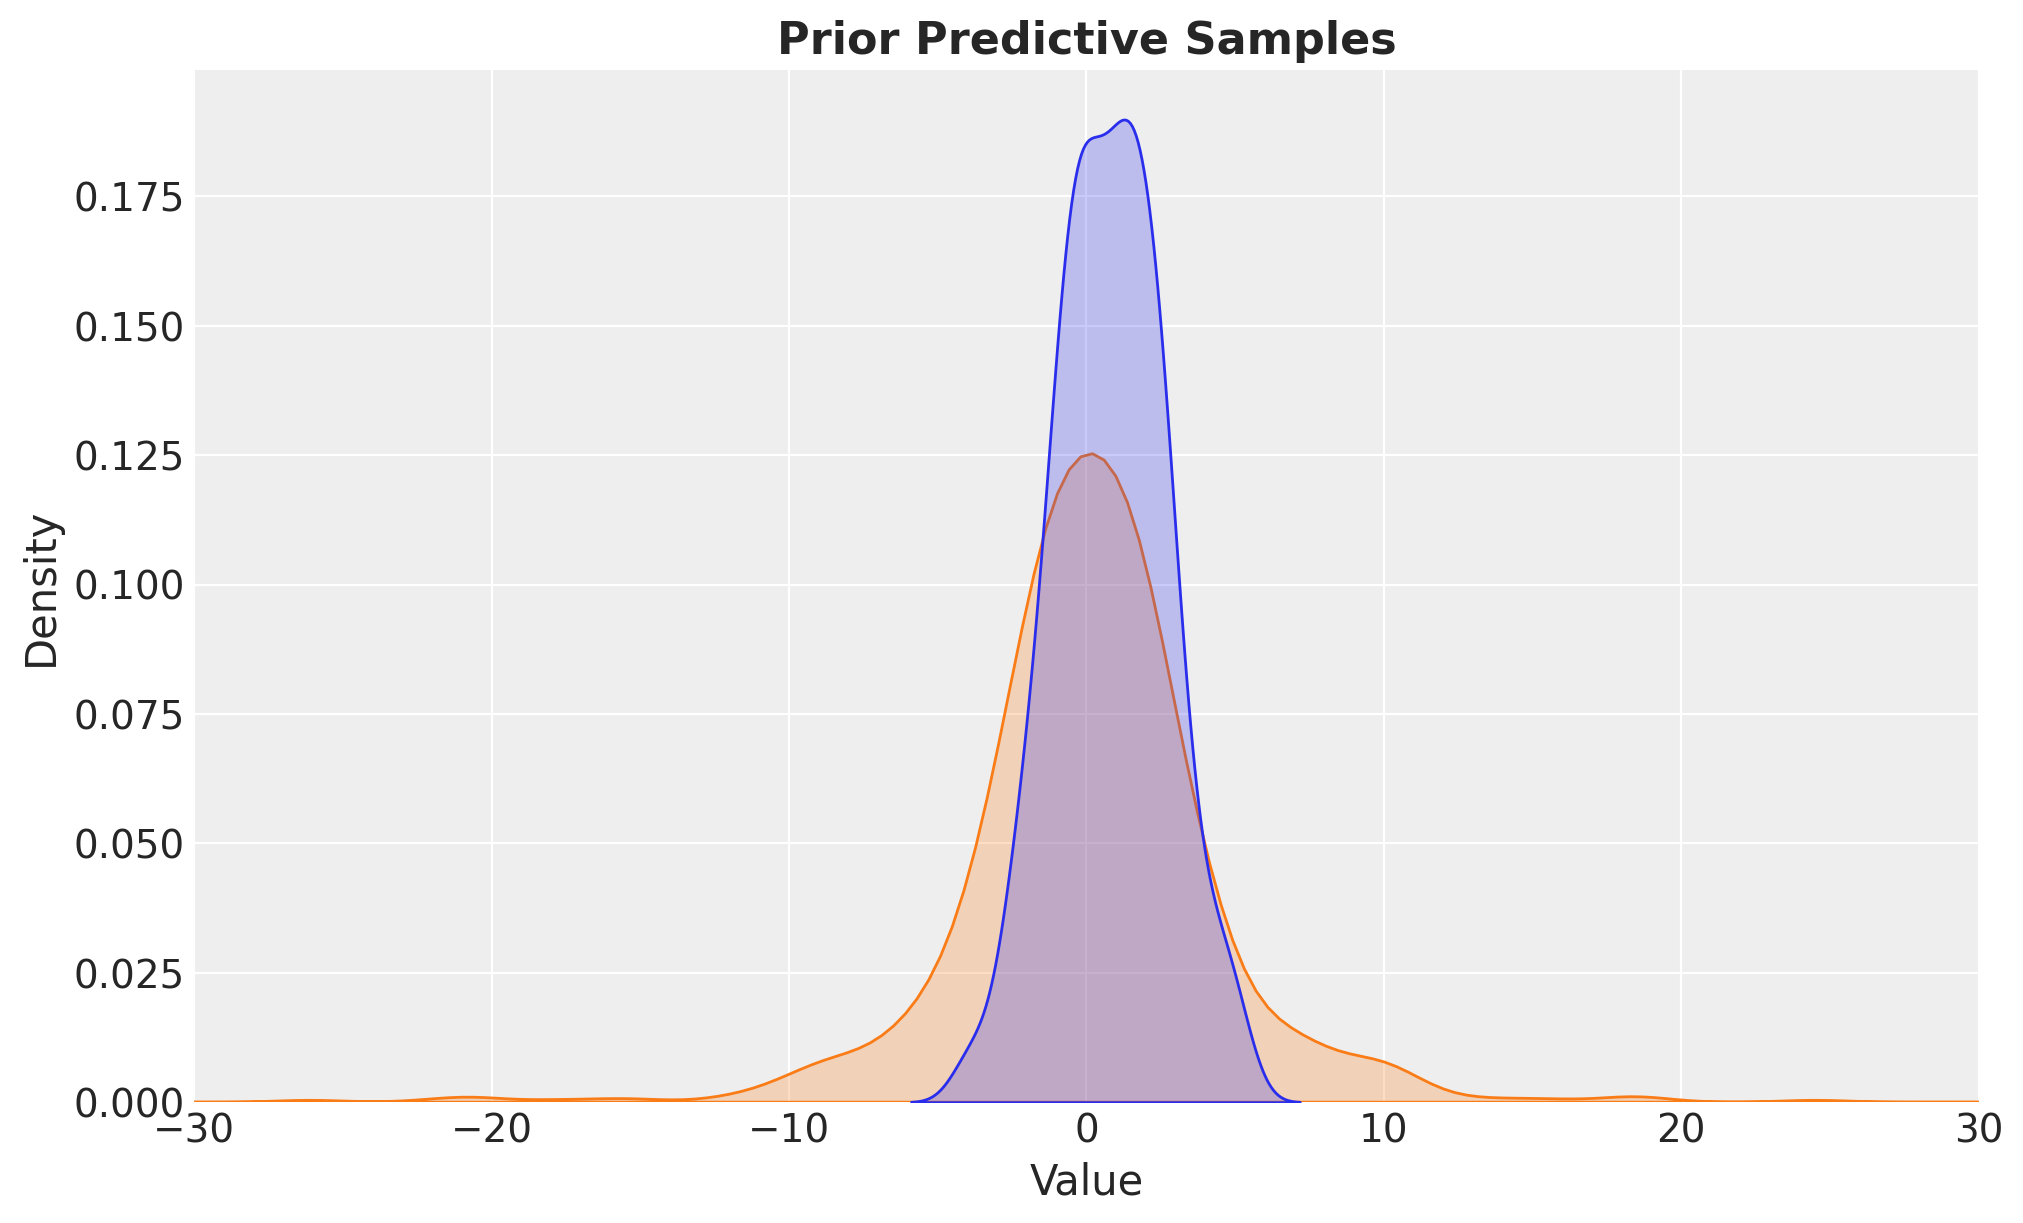

In [7]:
prior_predictive_samples = rng.normal(loc=mus, scale=sigmas)

fig, ax = plt.subplots()
sns.kdeplot(prior_predictive_samples, fill=True, color="C1", ax=ax)
sns.kdeplot(data, fill=True, color="C0", ax=ax)
ax.set(xlim=(-30, 30))
ax.set(xlabel="Value", ylabel="Density")
ax.set_title("Prior Predictive Samples", fontsize=16, fontweight="bold");

The prior predictive check shows a good agreement between our simulated data and the prior predictive samples. The overlapping densities indicate that our chosen prior distributions for the mean (normal) and standard deviation (lognormal) are reasonable and can generate data similar to what we observe. This suggests our prior specifications are appropriate for this modeling task.


### Prior Predictive Sampling with PyMC

We start by defining the model in PyMC. Note that we do not need to pass the observed data (yet) in order to sample from the prior predictive distribution.

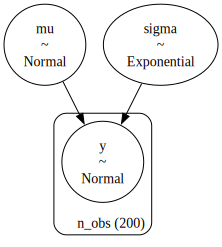

In [8]:
with pm.Model(coords={"n_obs": range(data.shape[0])}) as model:
    # Define the prior distributions
    mu = pm.Normal("mu", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1 / 3)

    # Define the likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, dims="n_obs")

model.to_graphviz()

PyMC offers a convenient way to sample from the prior predictive distribution using the {func}`pymc.sample_prior_predictive <pymc.sample_prior_predictive>` function.

In [9]:
with model:
    # Sample from the prior predictive distribution
    idata = pm.sample_prior_predictive(samples=n_prior_samples)

Sampling: [mu, sigma, y]


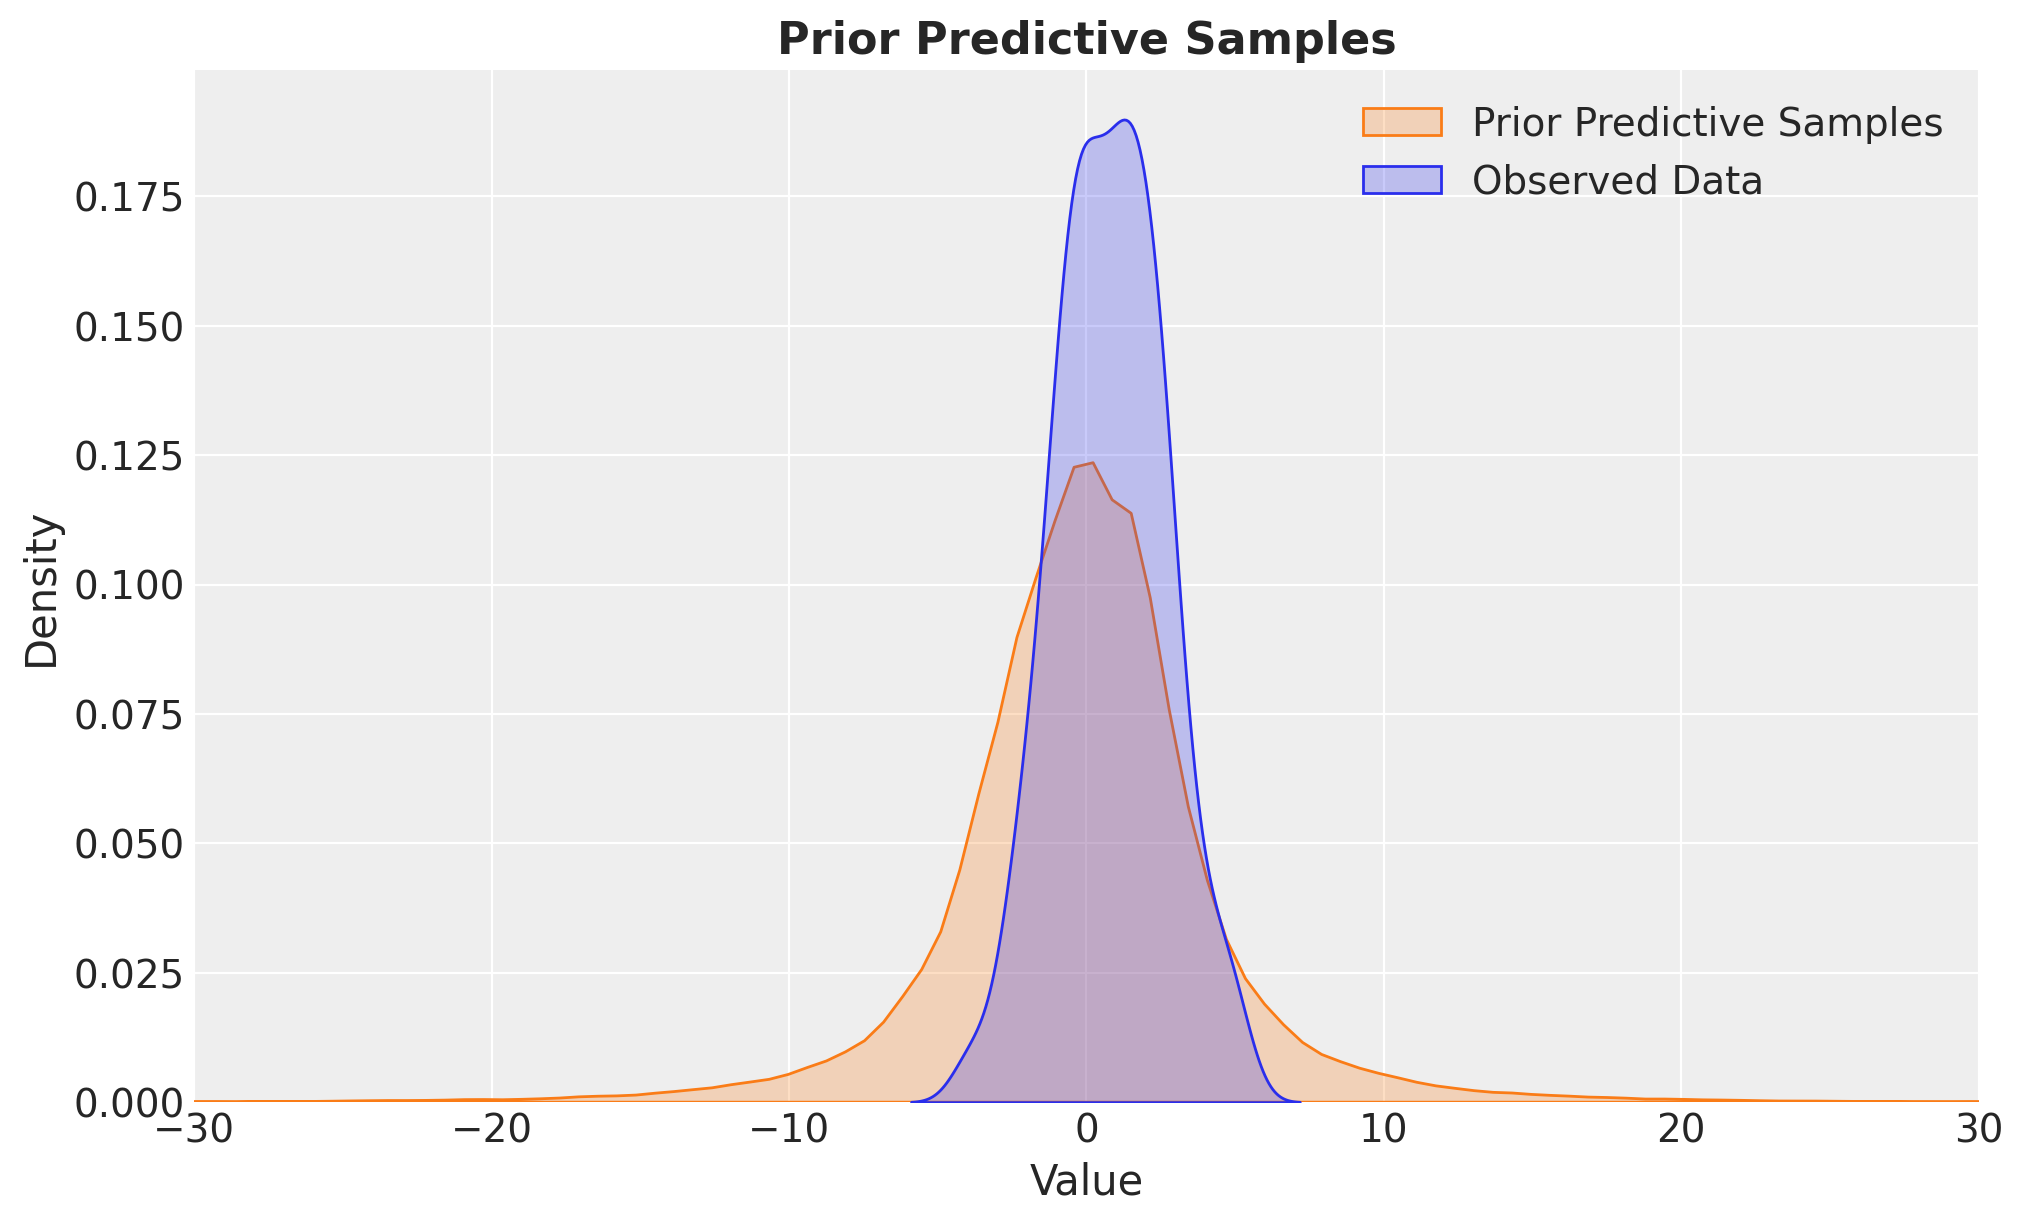

In [10]:
fig, ax = plt.subplots()
sns.kdeplot(
    idata["prior"]["y"].to_numpy().flatten(),
    fill=True,
    color="C1",
    label="Prior Predictive Samples",
    ax=ax,
)
sns.kdeplot(data, fill=True, color="C0", label="Observed Data", ax=ax)
ax.legend()
ax.set(xlabel="Value", ylabel="Density", xlim=(-30, 30))
ax.set_title("Prior Predictive Samples", fontsize=16, fontweight="bold");

The prior predictive samples are very similar to the ones obtained from the manual sampling.

### Posterior Predictive Sampling

Now we can fit the model to the observed data and sample from the posterior predictive distribution.

In [11]:
# Condition the model on the observed data
conditioned_model = pm.observe(model, {"y": data})

# Sample
with conditioned_model:
    # Sample from the posterior distribution
    idata.extend(pm.sample())
    # Sample from the posterior predictive distribution
    idata.extend(pm.sample_posterior_predictive(idata))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


Output()

Let's plot the posterior distributions of the mean and standard deviation parameters.

Text(0.5, 0.98, 'Posterior Distributions')

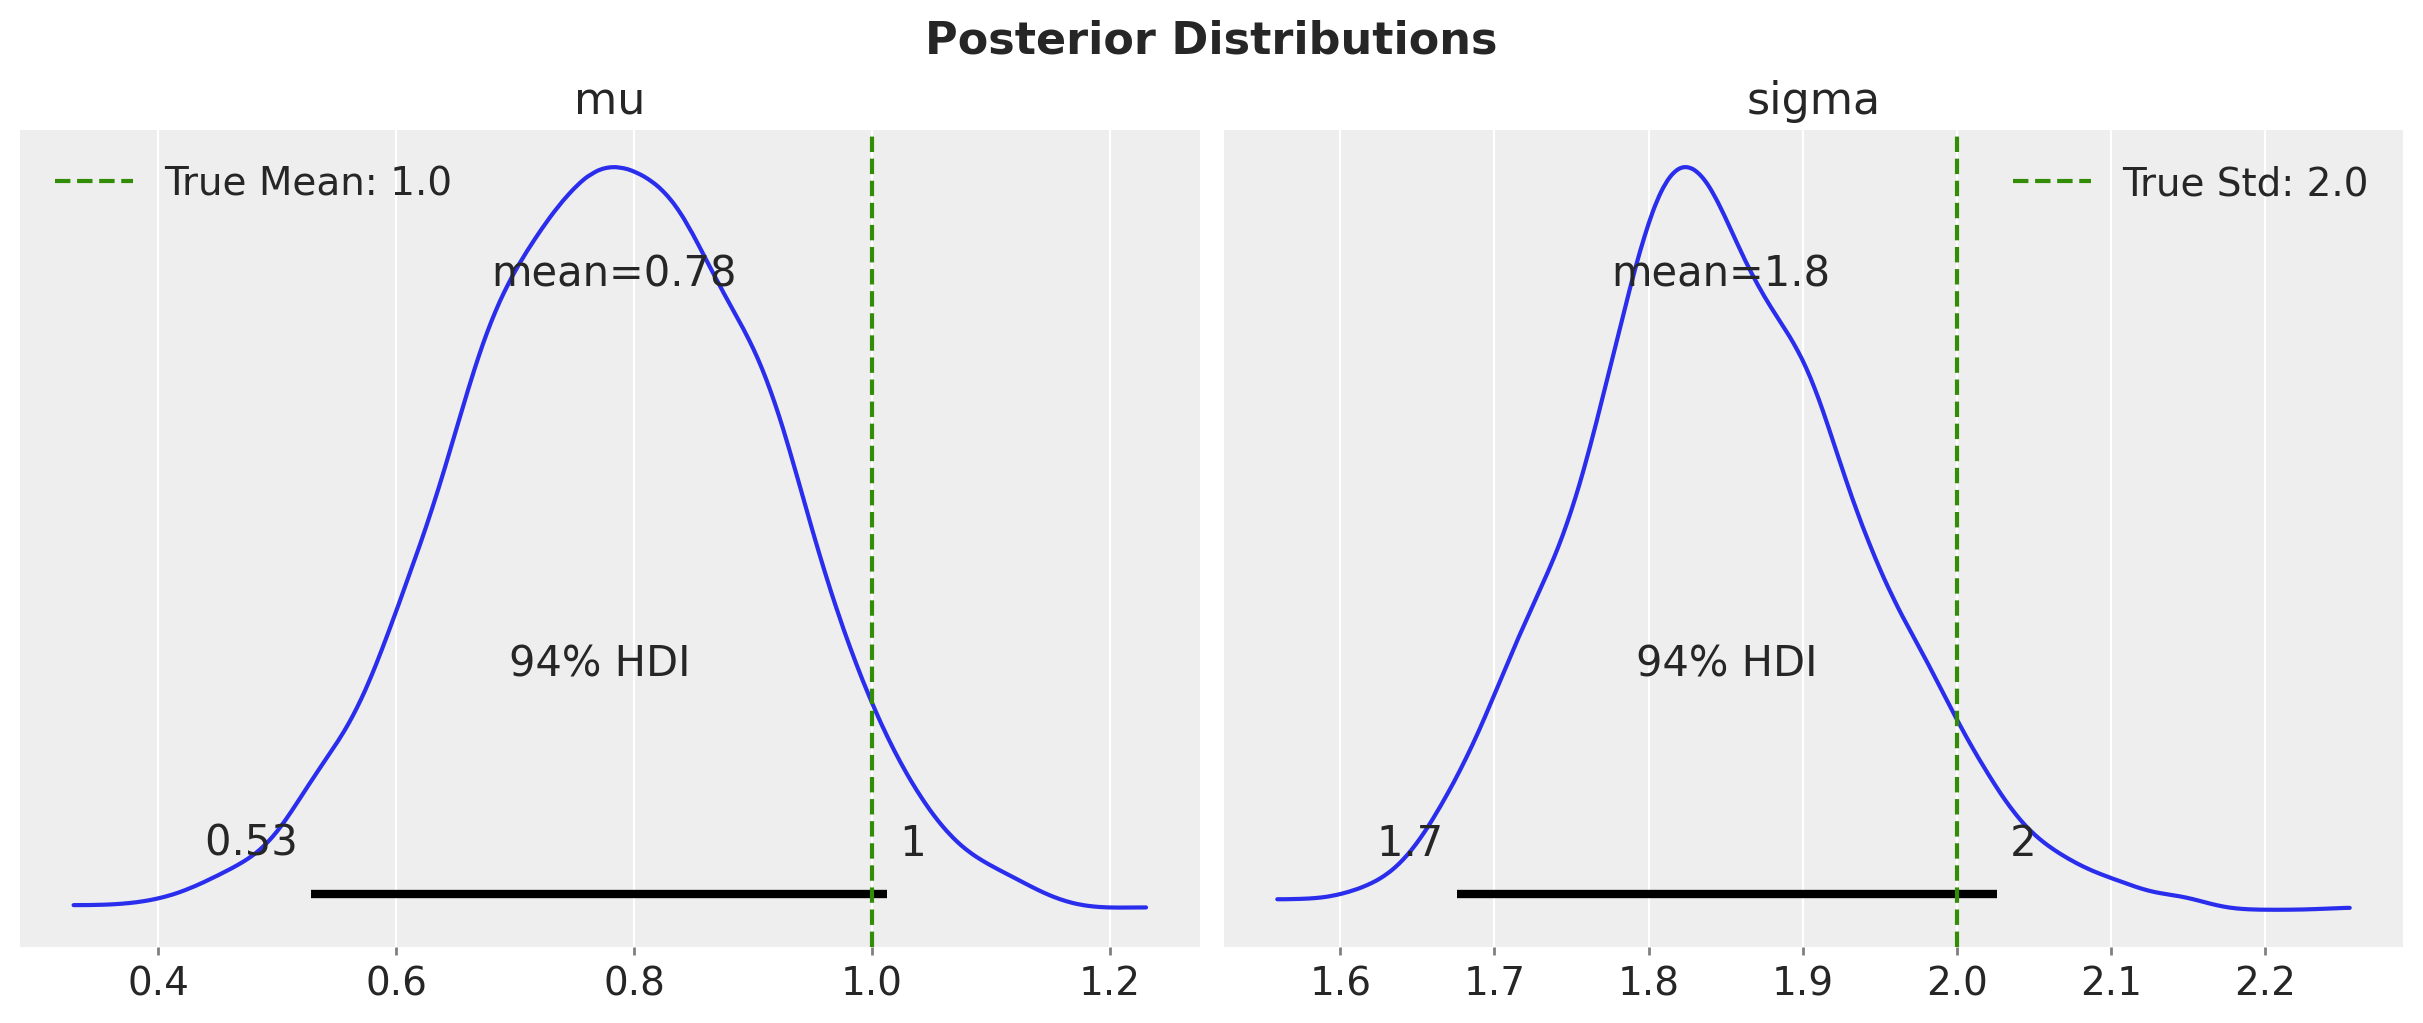

In [12]:
axes = az.plot_posterior(idata, var_names=["mu", "sigma"], figsize=(12, 5))

axes[0].axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.1f}")
axes[1].axvline(
    true_sigma, color="C2", linestyle="--", label=f"True Std: {true_sigma:.1f}"
)
axes[0].legend()
axes[1].legend()

fig = plt.gcf()
fig.suptitle("Posterior Distributions", fontsize=16, fontweight="bold")

We obtain values very close to the true values (this is known as parameter recovery).

We can compare the prior and posterior distributions of the mean and standard deviation parameters. These plots are very handy to understand the impact of the data on the parameters.

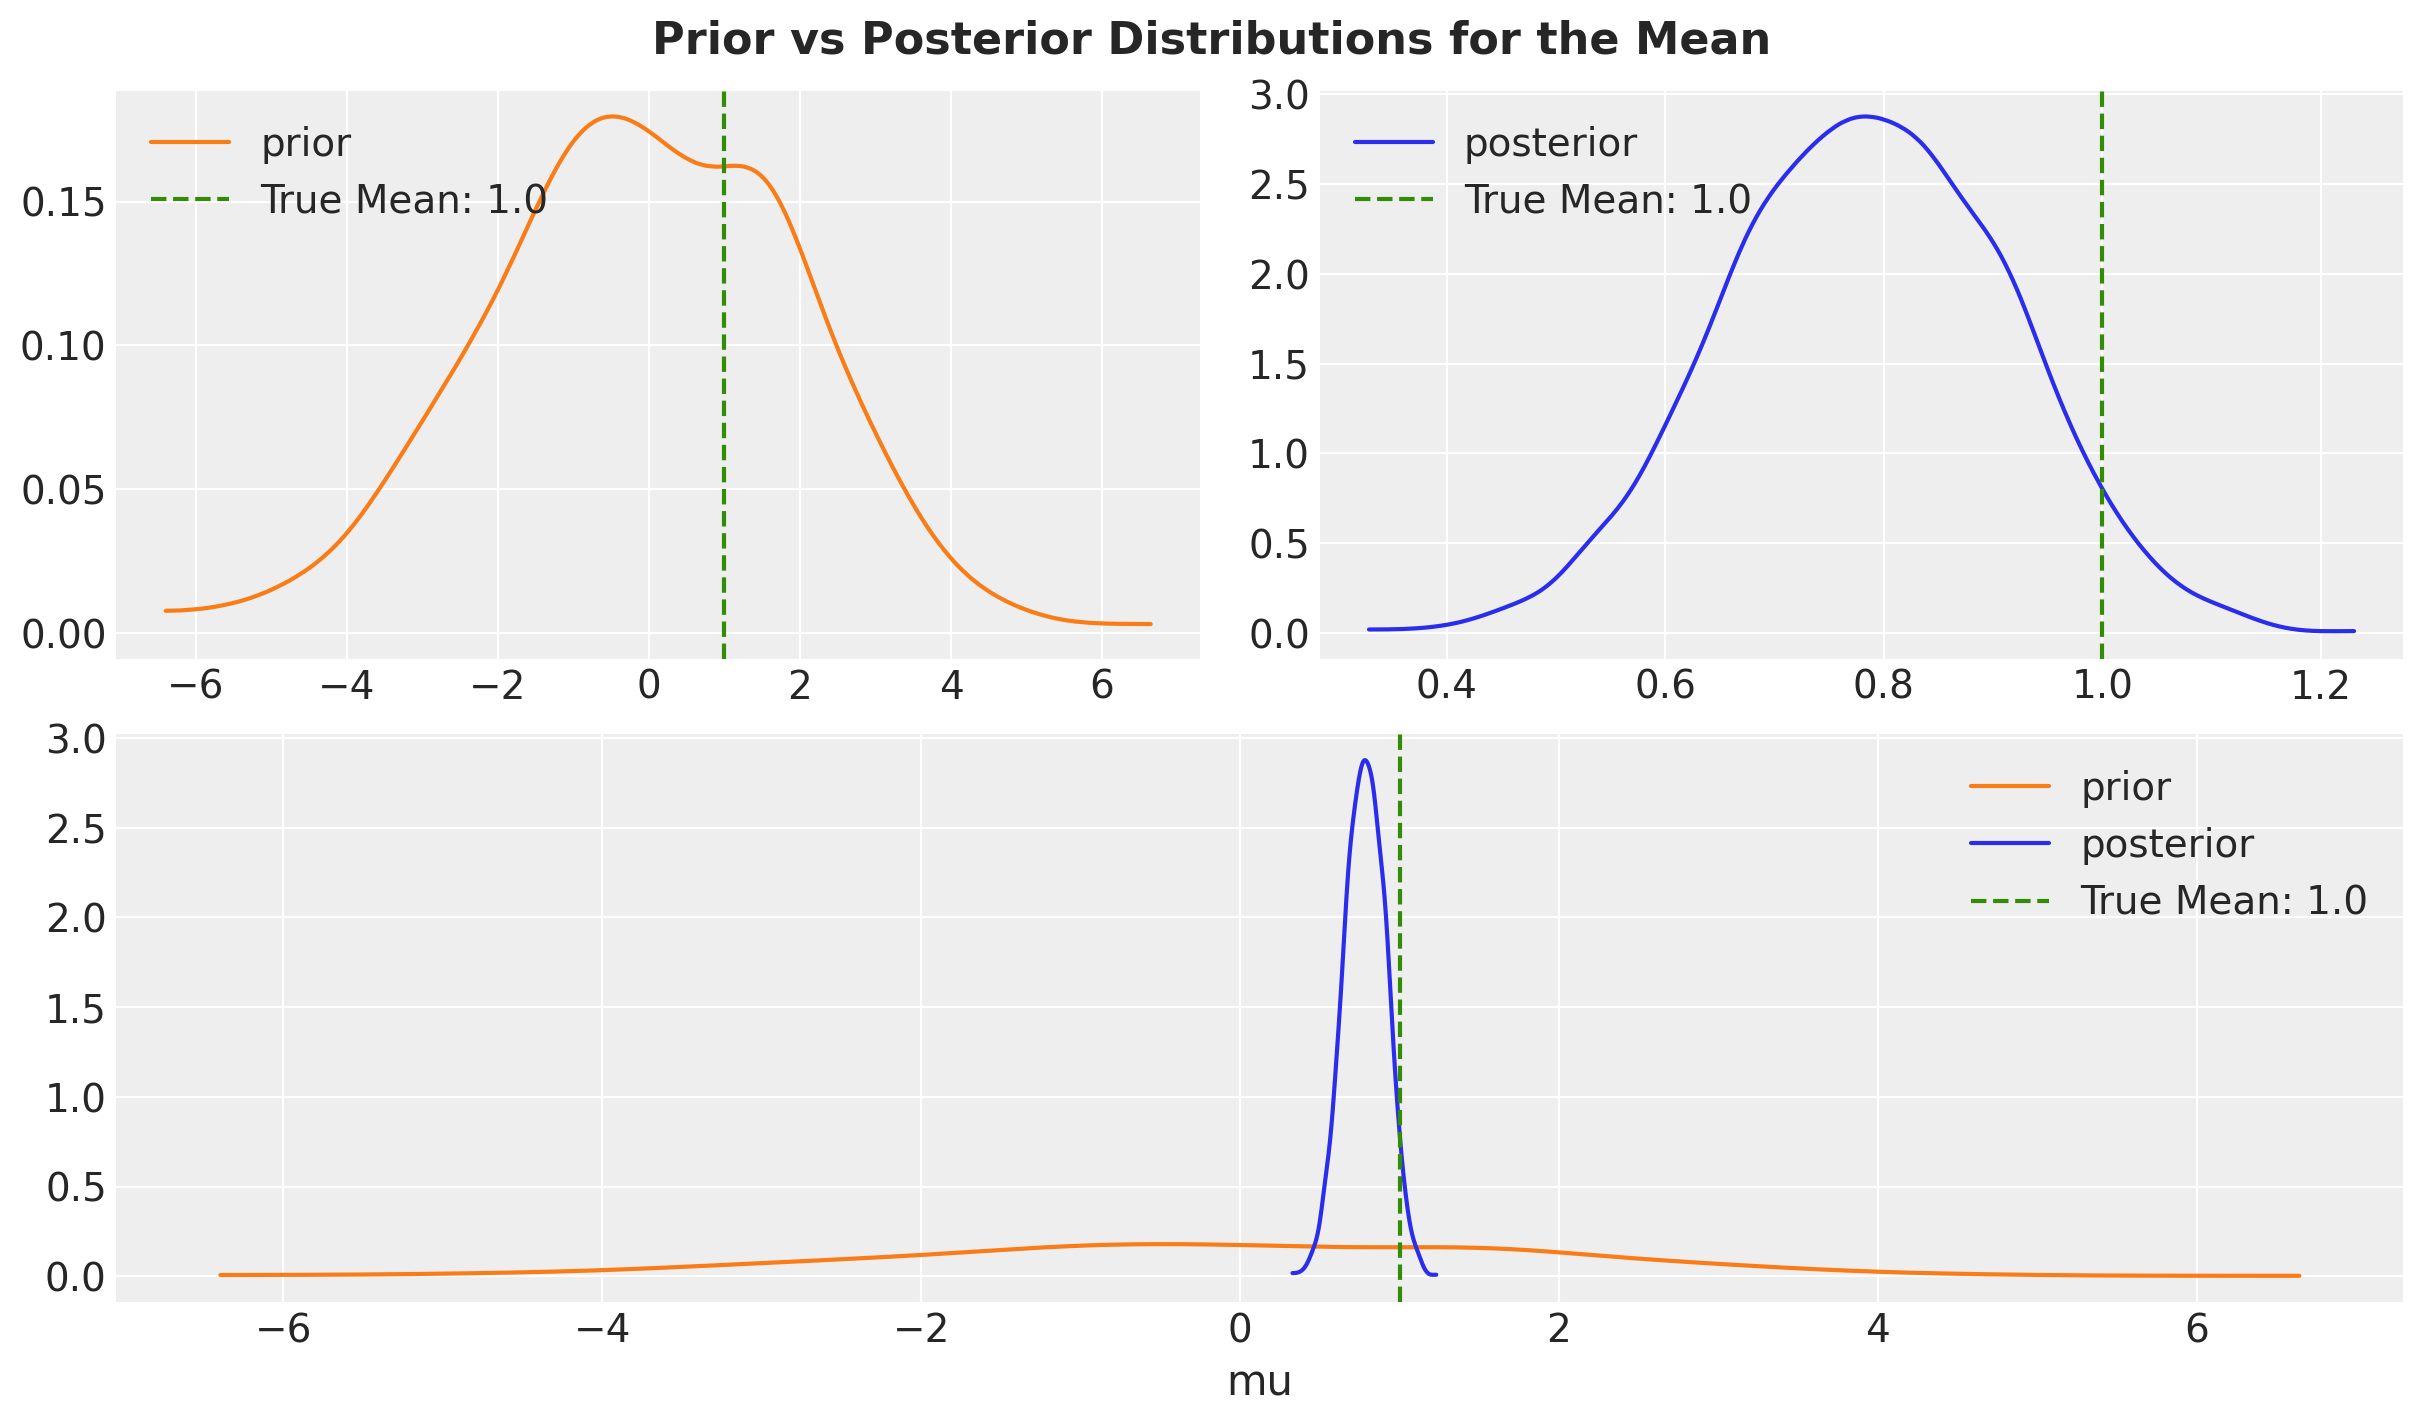

In [13]:
axes = az.plot_dist_comparison(idata, var_names=["mu"], figsize=(12, 7))
axes = axes.flatten()
for ax in axes:
    ax.axvline(true_mu, color="C2", linestyle="--", label=f"True Mean: {true_mu:.1f}")
    ax.legend()
fig = plt.gcf()
fig.suptitle(
    "Prior vs Posterior Distributions for the Mean", fontsize=16, fontweight="bold"
);

Text(0.5, 0.98, 'Prior vs Posterior Distributions for the Standard Deviation')

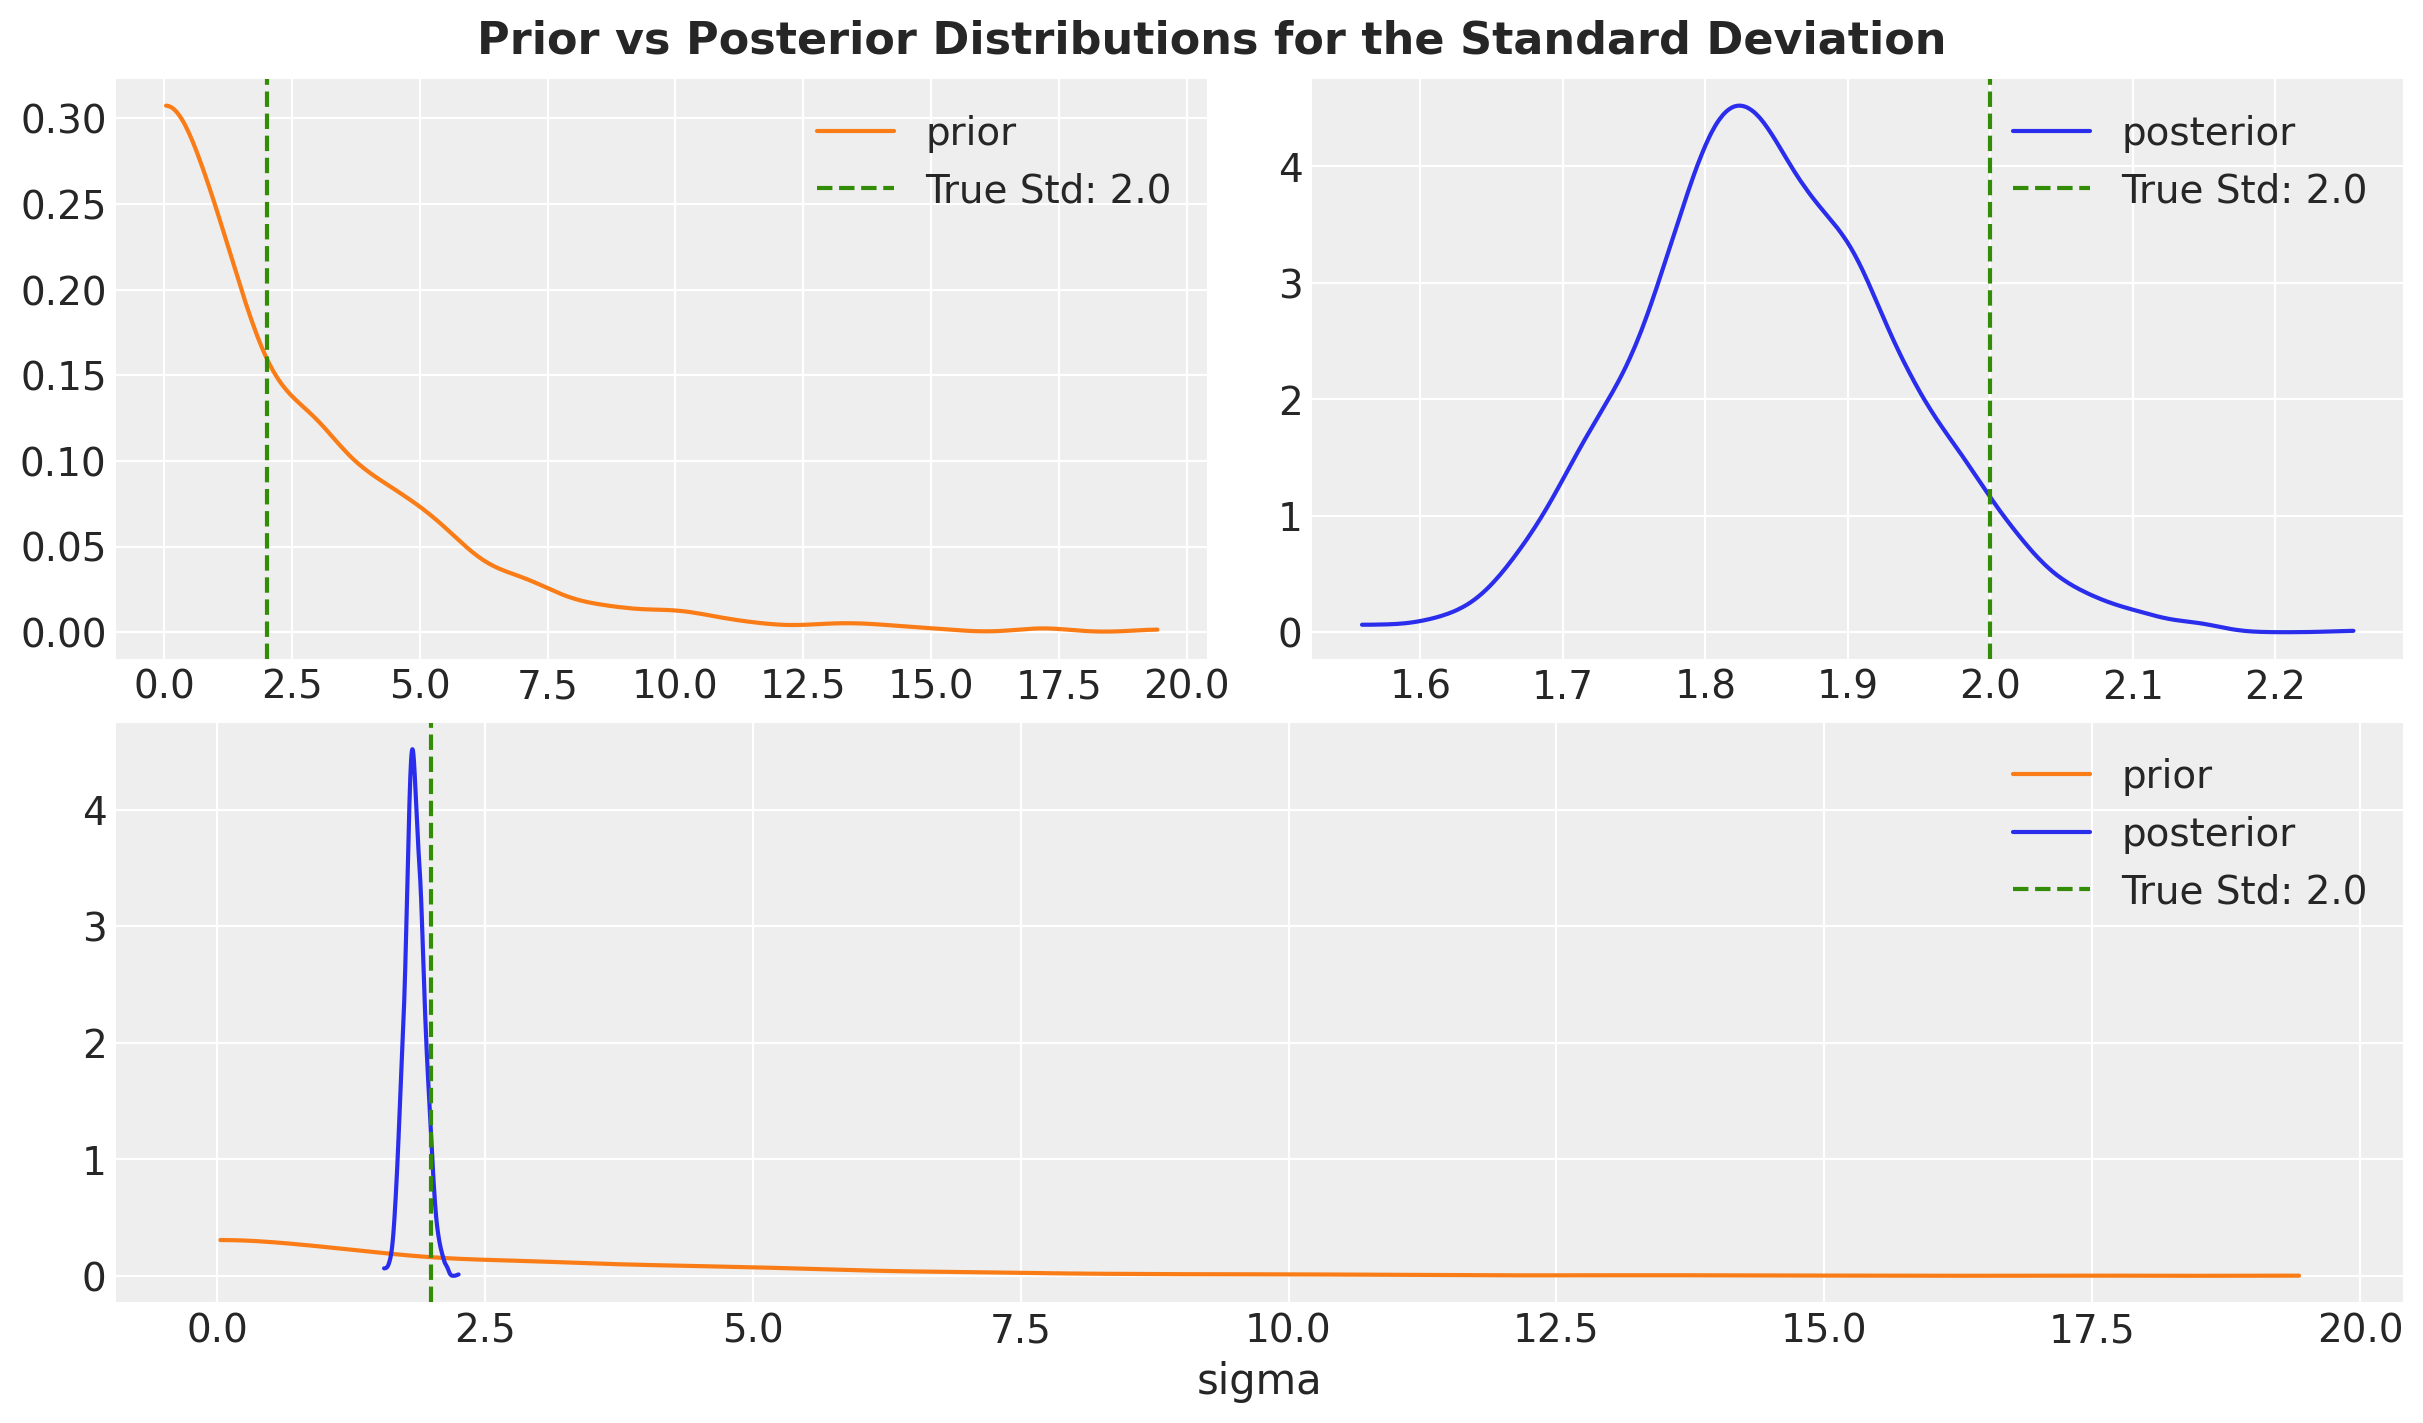

In [14]:
axes = az.plot_dist_comparison(idata, var_names=["sigma"], figsize=(12, 7))
axes = axes.flatten()
for ax in axes:
    ax.axvline(
        true_sigma, color="C2", linestyle="--", label=f"True Std: {true_sigma:.1f}"
    )
    ax.legend()
fig = plt.gcf()
fig.suptitle(
    "Prior vs Posterior Distributions for the Standard Deviation",
    fontsize=16,
    fontweight="bold",
)

Finally, we can plot the posterior predictive distribution vs the observed data.

Text(0.5, 1.0, 'Posterior Predictive Samples')

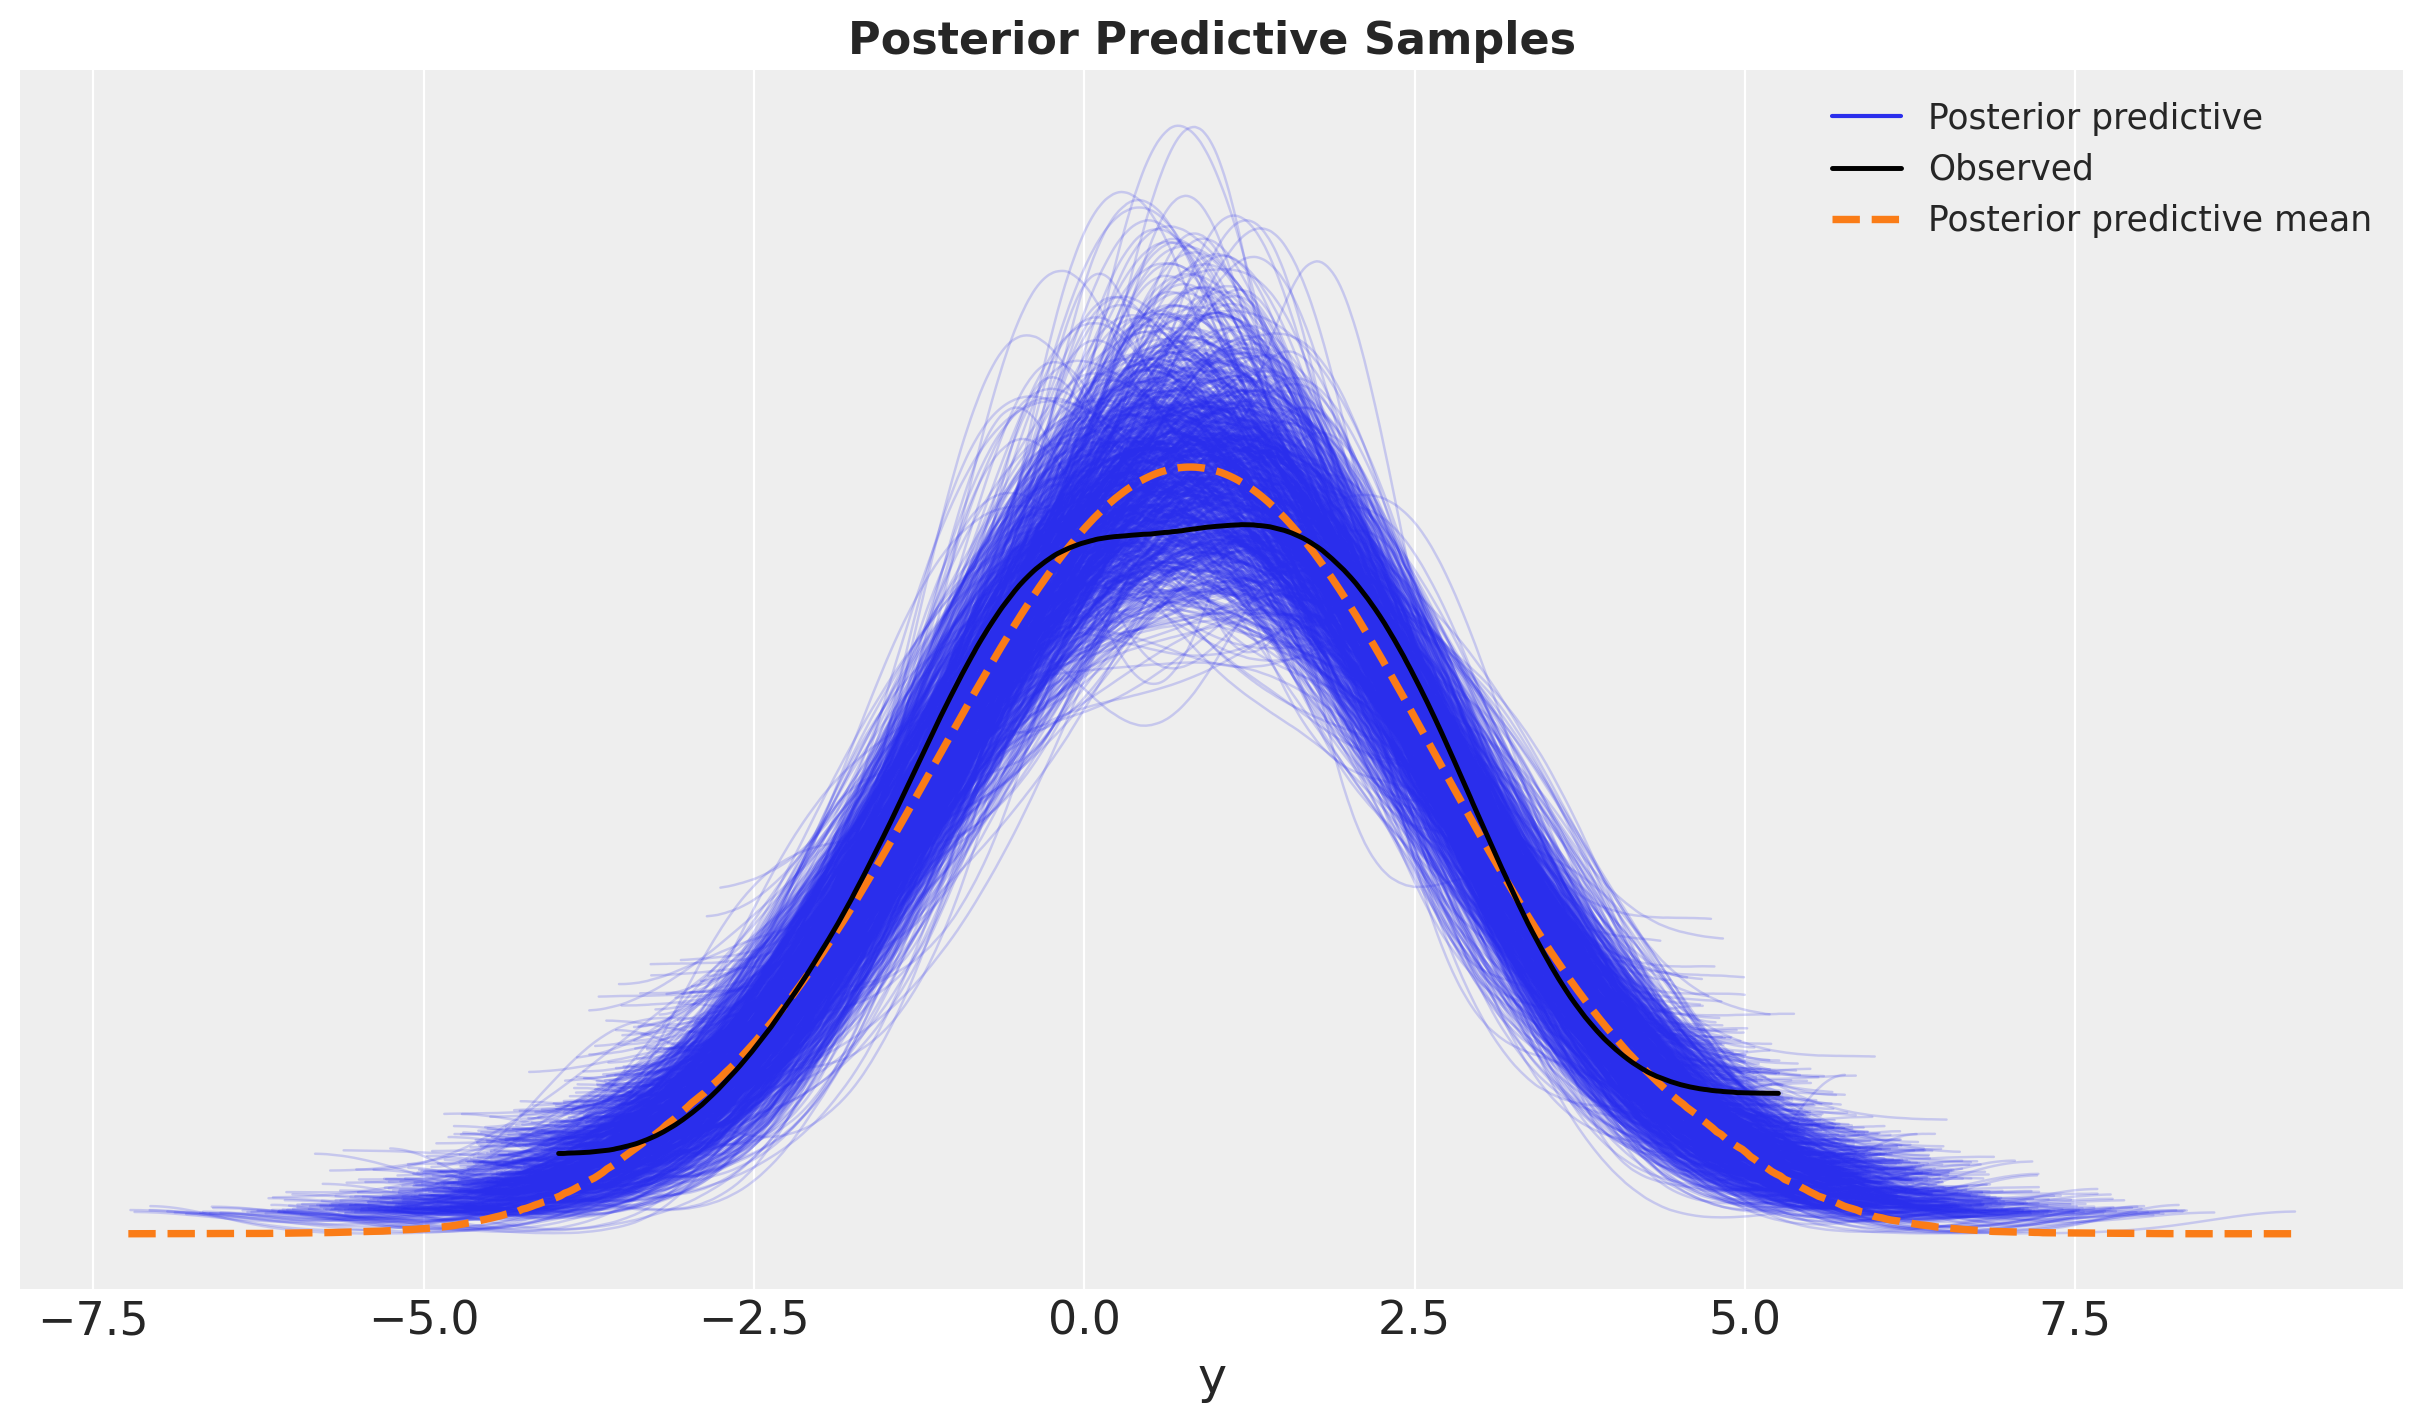

In [15]:
ax = az.plot_ppc(idata, var_names=["y"], num_pp_samples=1_000, figsize=(12, 7))
ax.set_title("Posterior Predictive Samples", fontsize=16, fontweight="bold")

We see that the posterior predictive distribution is very similar to the observed data. This is a good sign that our model is well specified.

## Prior Predictive Sampling for Marketing Mix Models

In [17]:
data_path = data_dir / "mmm_example.csv"

data_df = pd.read_csv(data_path, parse_dates=["date_week"])

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_week  179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


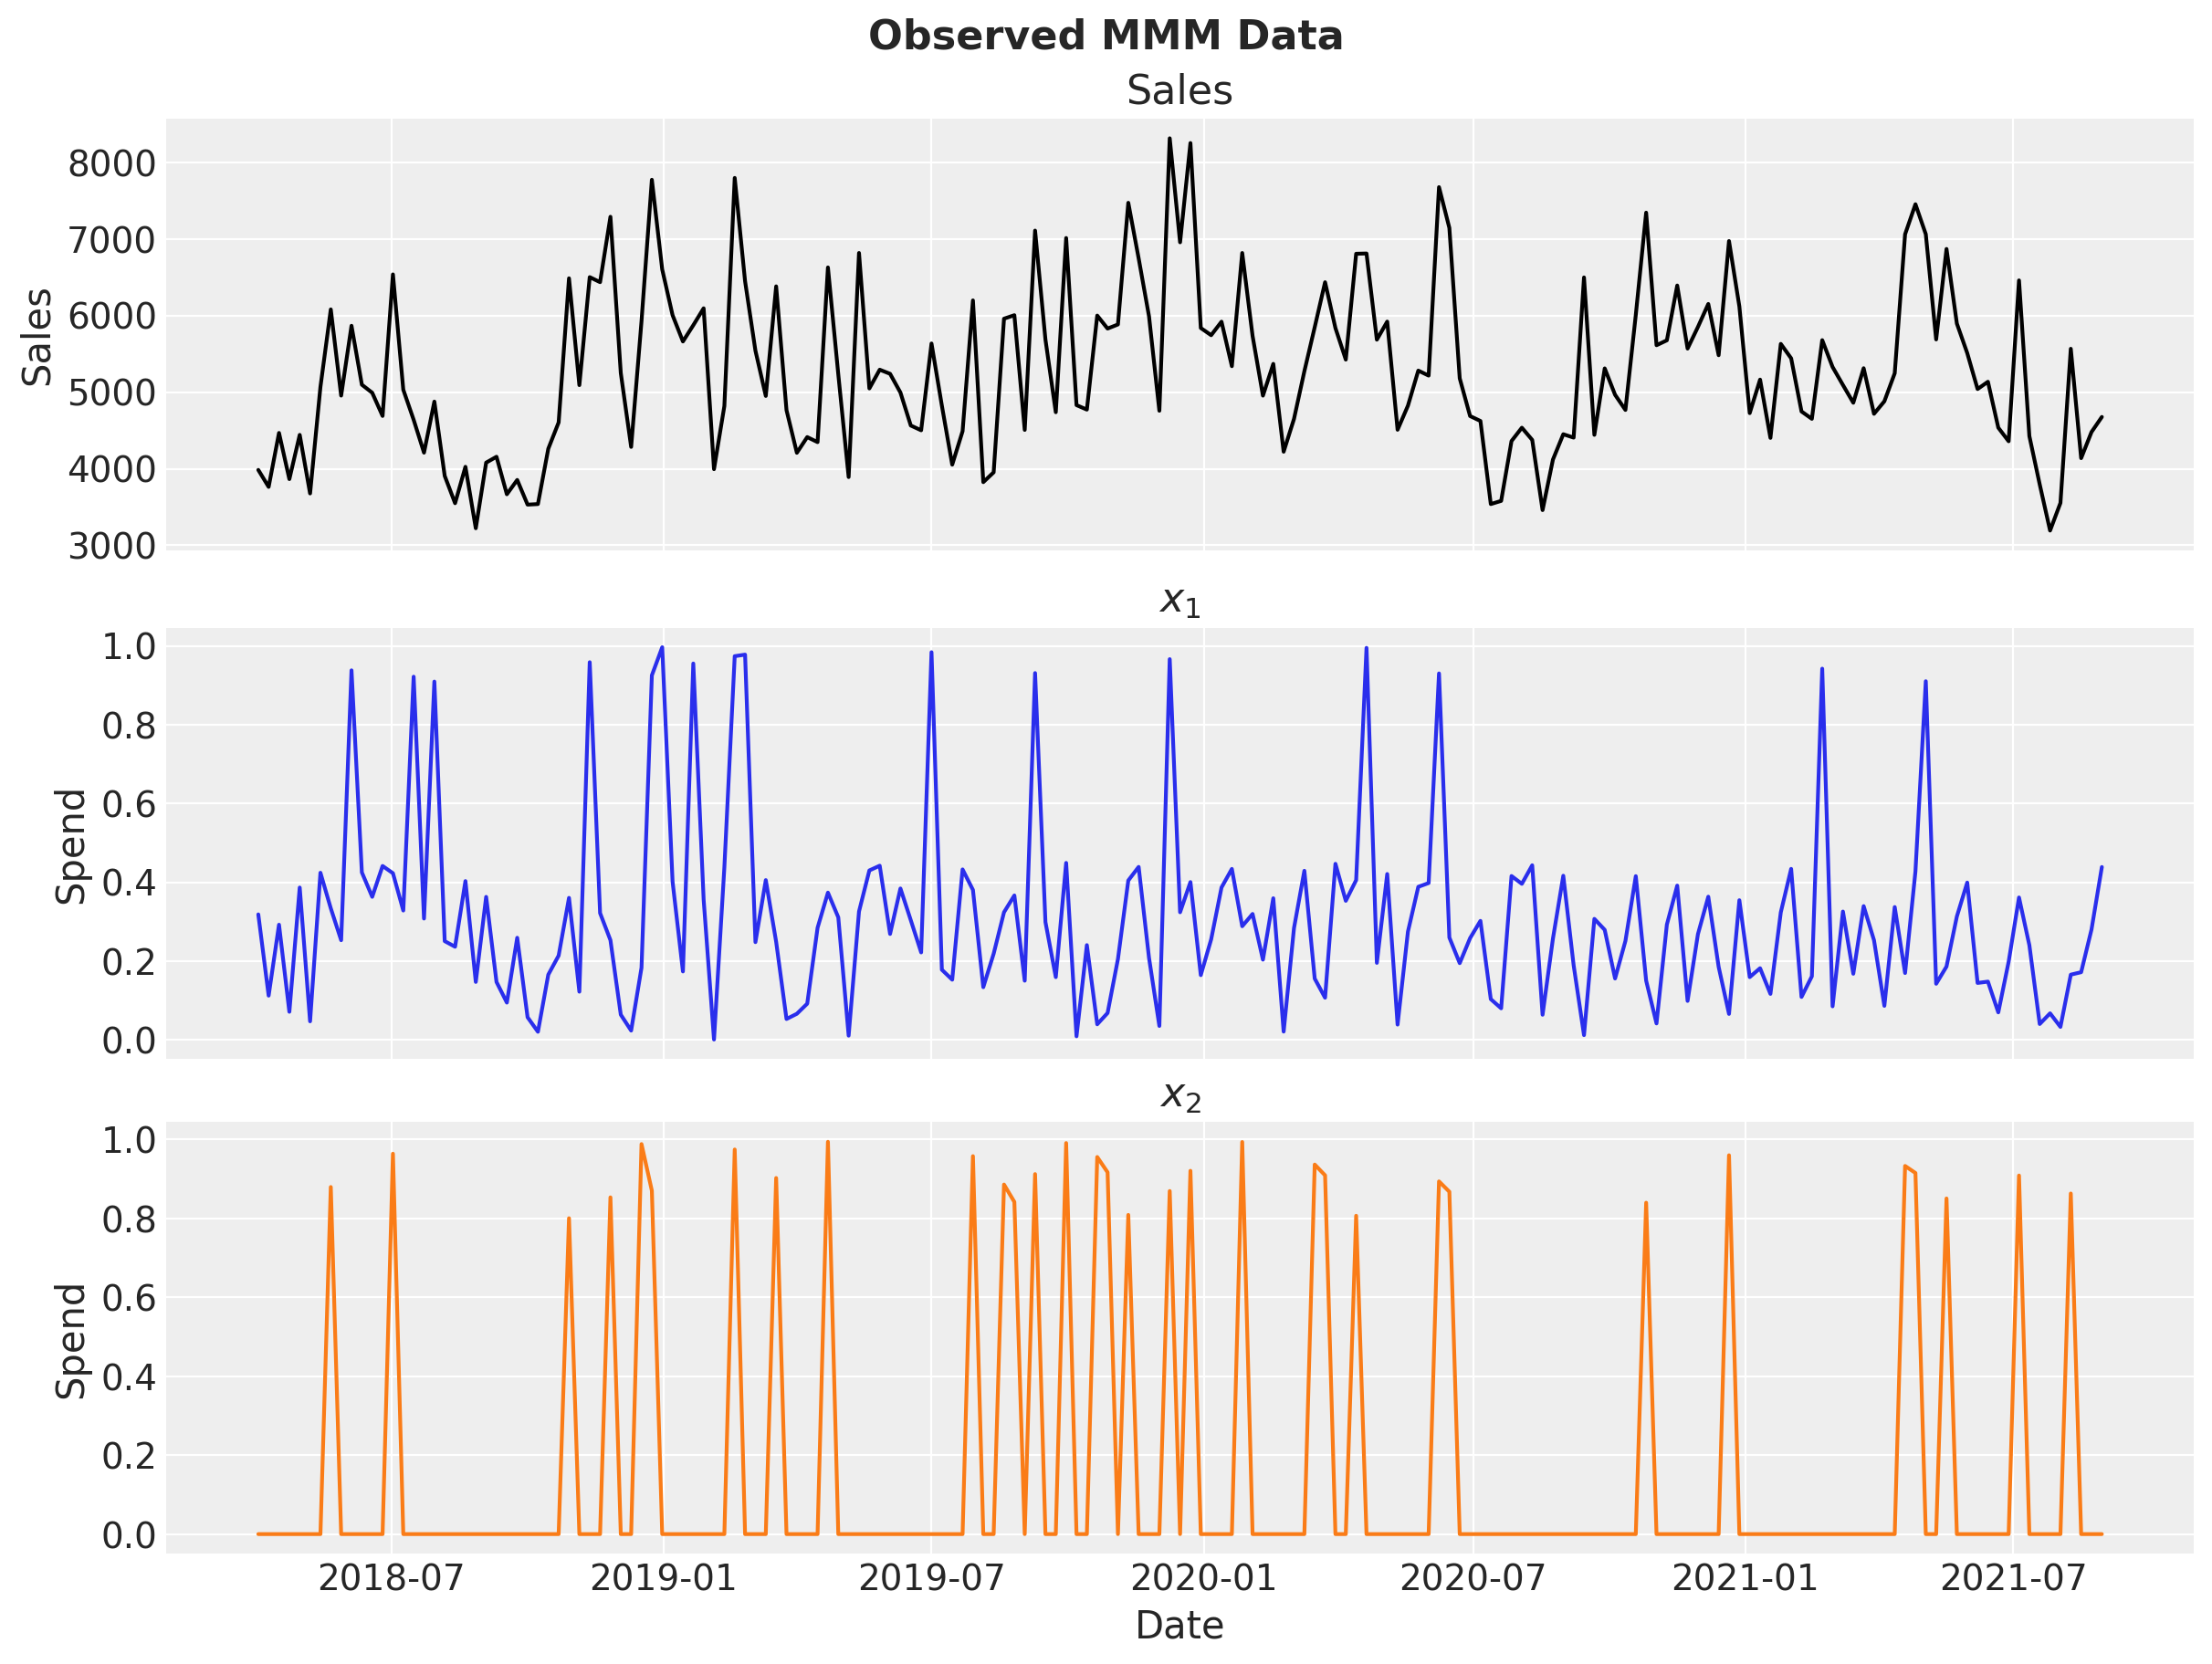

In [25]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)

sns.lineplot(data=data_df, x="date_week", y="y", color="black", ax=ax[0])
ax[0].set(title="Sales", xlabel="Date", ylabel="Sales")

sns.lineplot(data=data_df, x="date_week", y="x1", color="C0", ax=ax[1])
ax[1].set(title=r"$x_1$", xlabel="Date", ylabel="Spend")

sns.lineplot(data=data_df, x="date_week", y="x2", color="C1", ax=ax[2])
ax[2].set(title=r"$x_2$", xlabel="Date", ylabel="Spend")

fig.suptitle("Observed MMM Data", fontsize=16, fontweight="bold");

In [35]:
channel_columns = ["x1", "x2"]

n_channels = len(channel_columns)

total_spend_per_channel = data_df[channel_columns].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

prior_sigma = n_channels * spend_share.to_numpy()

In [36]:
my_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigma),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [38]:
mmm = MMM(
    model_config=my_model_config,
    date_column="date_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=channel_columns,
    control_columns=["event_1", "event_2", "t"],
    yearly_seasonality=2,
)

In [39]:
X = data_df.drop("y", axis=1)
y = data_df["y"]


# Generate prior predictive samples
_ = mmm.sample_prior_predictive(X, y, samples=2_000)

Sampling: [adstock_alpha, gamma_control, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]


<xarray.Dataset> Size: 3MB
Dimensions:  (date: 179, sample: 2000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    y        (date, sample) float64 3MB -1.217 2.706 -0.5076 ... 19.6 19.7 5.301
Attributes:
    created_at:                 2025-01-04T10:20:20.378746+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.15.1

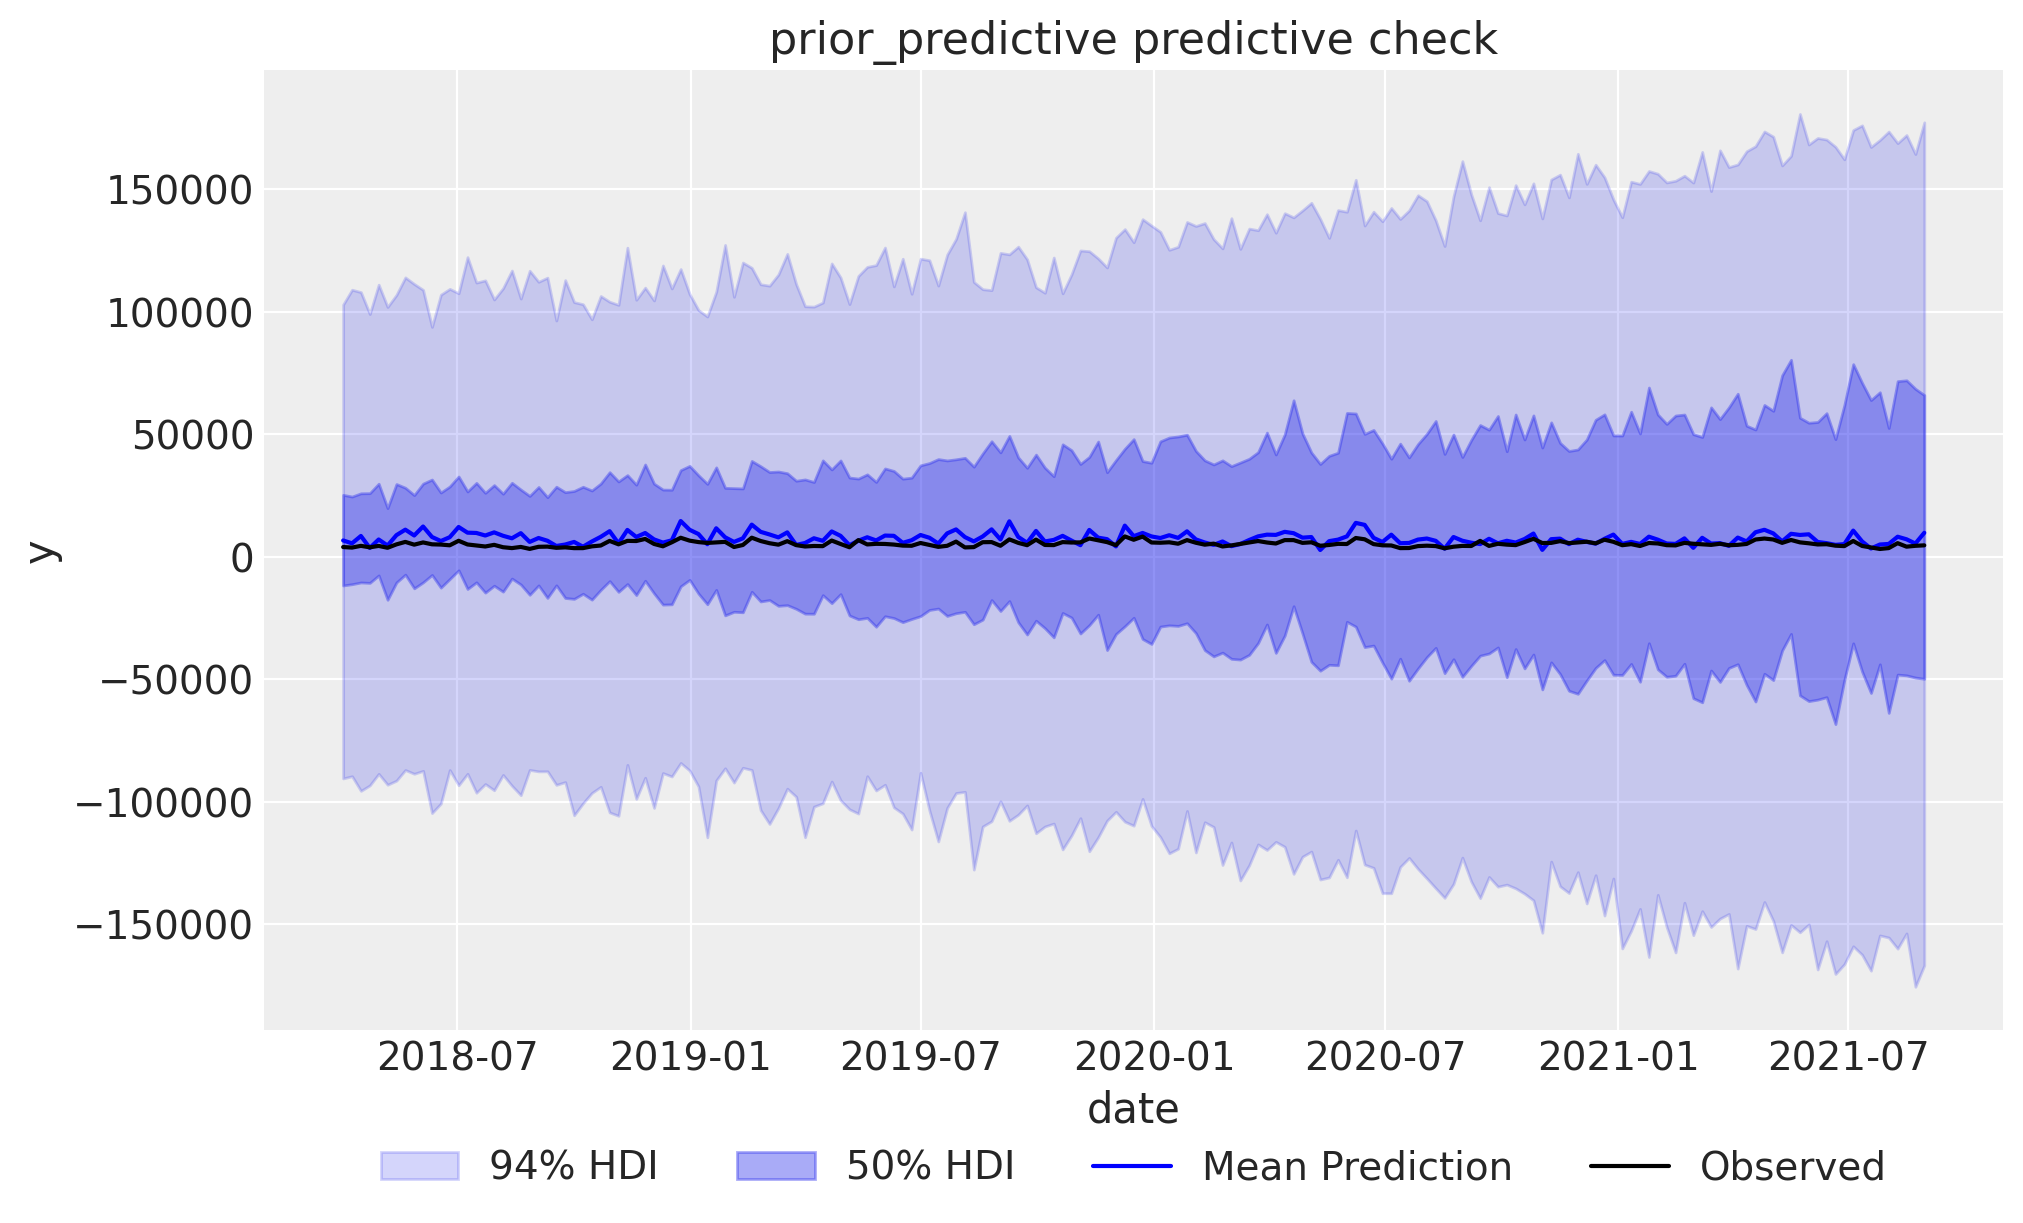

In [42]:
fig, ax = plt.subplots()
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);